# Imports

In [7]:
import numpy as np
import pandas as pd
from polars import read_csv as pl_read_csv
import polars as pl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from tqdm import tqdm, trange
import matplotlib.lines as mlines
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

plt.style.use('dark_background')
pd.options.mode.chained_assignment = None

In [8]:
def generate_stat(folder, eval_quantiles, agent_name, return_resutls=False):

    eval_df = pl_read_csv(folder, n_threads=8).to_pandas()
    eval_loop_df = eval_df[['episode', 'step_pnl', 'hed_cost']].groupby('episode').aggregate('sum')
    eval_loop_df.columns = ['episode_return', 'tc']
    
    gamma_exposure_df = eval_df[['episode', 'gamma_before_hedge', 'gamma_after_hedge']]
    gamma_exposure_df['gamma_hedged_amount'] = (gamma_exposure_df['gamma_before_hedge'] - gamma_exposure_df['gamma_after_hedge']) * np.sign(gamma_exposure_df['gamma_before_hedge'])
    gamma_exposure_df['gamma_before_hedge_level'] = gamma_exposure_df['gamma_before_hedge'].abs()
    gamma_exposure_df = gamma_exposure_df.groupby('episode').aggregate('sum')
    gamma_exposure = gamma_exposure_df['gamma_hedged_amount'] / gamma_exposure_df['gamma_before_hedge_level']
    
    vega_exposure_df = eval_df[['episode', 'vega_before_hedge', 'vega_after_hedge']]
    vega_exposure_df['vega_hedged_amount'] = (vega_exposure_df['vega_before_hedge'] - vega_exposure_df['vega_after_hedge']) * np.sign(vega_exposure_df['vega_before_hedge'])
    vega_exposure_df['vega_before_hedge_level'] = vega_exposure_df['vega_before_hedge'].abs()
    vega_exposure_df = vega_exposure_df.groupby('episode').aggregate('sum')
    vega_exposure = vega_exposure_df['vega_hedged_amount'] / vega_exposure_df['vega_before_hedge_level']

    # Calculate BCa Bootstrap Confidence Interval for 'episode_return'
    pnl_data = eval_loop_df['episode_return'].values
    pnl_std  = eval_loop_df['episode_return'].std()
    pnl_bootstrap = bs.bootstrap(pnl_data, stat_func=bs_stats.mean, alpha=0.05, num_iterations=10000, num_threads=16)
    pnl_mean = pnl_bootstrap.value
    pnl_half_width = (pnl_bootstrap.upper_bound - pnl_bootstrap.lower_bound) / 2

    # Calculate BCa Bootstrap Confidence Interval for 'tc'
    tc_data = eval_loop_df['tc'].values
    tc_bootstrap = bs.bootstrap( tc_data, stat_func=bs_stats.mean, alpha=0.05, num_iterations=10000, num_threads=16 )
    tc_mean = tc_bootstrap.value
    tc_half_width = (tc_bootstrap.upper_bound - tc_bootstrap.lower_bound) / 2

    # Returning statistics:
    mean_std = eval_loop_df['episode_return'].mean() - 1.645 * eval_loop_df['episode_return'].std()
    gamma_ratio = gamma_exposure.mean()
    vega_ratio = vega_exposure.mean()

    stats_str = (
        f"{agent_name:<20} pnl mean: {pnl_mean:<6.2f}(±{pnl_half_width:<4.2f}) | "
        f"std: {pnl_std:<10.5f} | "
        f"Mean-SD: {mean_std:<6.2f} | "
        f"gamma-ratio: {gamma_ratio:5.2f} ({gamma_exposure.quantile(0.10):5.2f}/{gamma_exposure.quantile(0.90):5.2f}) | "
        f"vega-ratio: {vega_ratio:5.2f} ({vega_exposure.quantile(0.10):5.2f}/{vega_exposure.quantile(0.90):5.2f})"
    )
    
    for q in eval_quantiles:
        stats_str += f"| var{100 * q:.0f}: {eval_loop_df['episode_return'].quantile(1 - q):8.2f} "
    
    for q in eval_quantiles:
        cvar_value = eval_loop_df.loc[
            eval_loop_df['episode_return'] <= eval_loop_df['episode_return'].quantile(1 - q),
            'episode_return'
        ].mean()
        stats_str += f"| cvar{100 * q:.0f}: {cvar_value:8.2f} "
    
    stats_str += f"| E[TC]: {tc_mean:<6.2f}(±{tc_half_width:<4.2f})"
    
    print(stats_str)
    if return_resutls:
        # pnl mean	std	Mean-SD	gamma-ratio	vega-ratio	var95	cvar95	E[TC]
        var95  = eval_loop_df['episode_return'].quantile(1 - .95)
        cvar95 = eval_loop_df.loc[eval_loop_df['episode_return'] <= var95, 'episode_return'].mean()
        return pnl_mean , pnl_std , mean_std , gamma_ratio , vega_ratio , var95 , cvar95 , tc_mean

# Define quantiles for evaluation
eval_quantiles = [0.95]

---------------------------------------
# Show Batched Experiments

## Spread 0.5% - Mean-Std

Heston Mean-Std 0.5%:0 pnl mean: -4.91 (±0.44) | std: 14.29160   | Mean-SD: -28.42 | gamma-ratio:  0.36( 0.03/ 0.64) | vega-ratio:  0.28( 0.11/ 0.40)| var95:   -28.71 | cvar95:   -40.92 | E[TC]: -3.93 (±0.05)
Heston Mean-Std 0.5%:1 pnl mean: -4.71 (±0.46) | std: 14.89356   | Mean-SD: -29.21 | gamma-ratio:  0.48( 0.08/ 0.74) | vega-ratio:  0.27( 0.08/ 0.47)| var95:   -28.20 | cvar95:   -39.92 | E[TC]: -3.78 (±0.03)
Heston Mean-Std 0.5%:2 pnl mean: -4.62 (±0.41) | std: 13.49318   | Mean-SD: -26.81 | gamma-ratio:  0.42( 0.06/ 0.75) | vega-ratio:  0.32( 0.14/ 0.51)| var95:   -26.27 | cvar95:   -36.82 | E[TC]: -3.97 (±0.04)
Heston Mean-Std 0.5%:3 pnl mean: -5.31 (±0.47) | std: 15.52176   | Mean-SD: -30.85 | gamma-ratio:  0.61( 0.26/ 0.87) | vega-ratio:  0.27( 0.09/ 0.47)| var95:   -30.68 | cvar95:   -43.18 | E[TC]: -4.57 (±0.06)
Heston Mean-Std 0.5%:4 pnl mean: -4.63 (±0.41) | std: 13.54687   | Mean-SD: -26.91 | gamma-ratio:  0.33( 0.01/ 0.68) | vega-ratio:  0.34( 0.18/ 0.47)| var95:   -26.

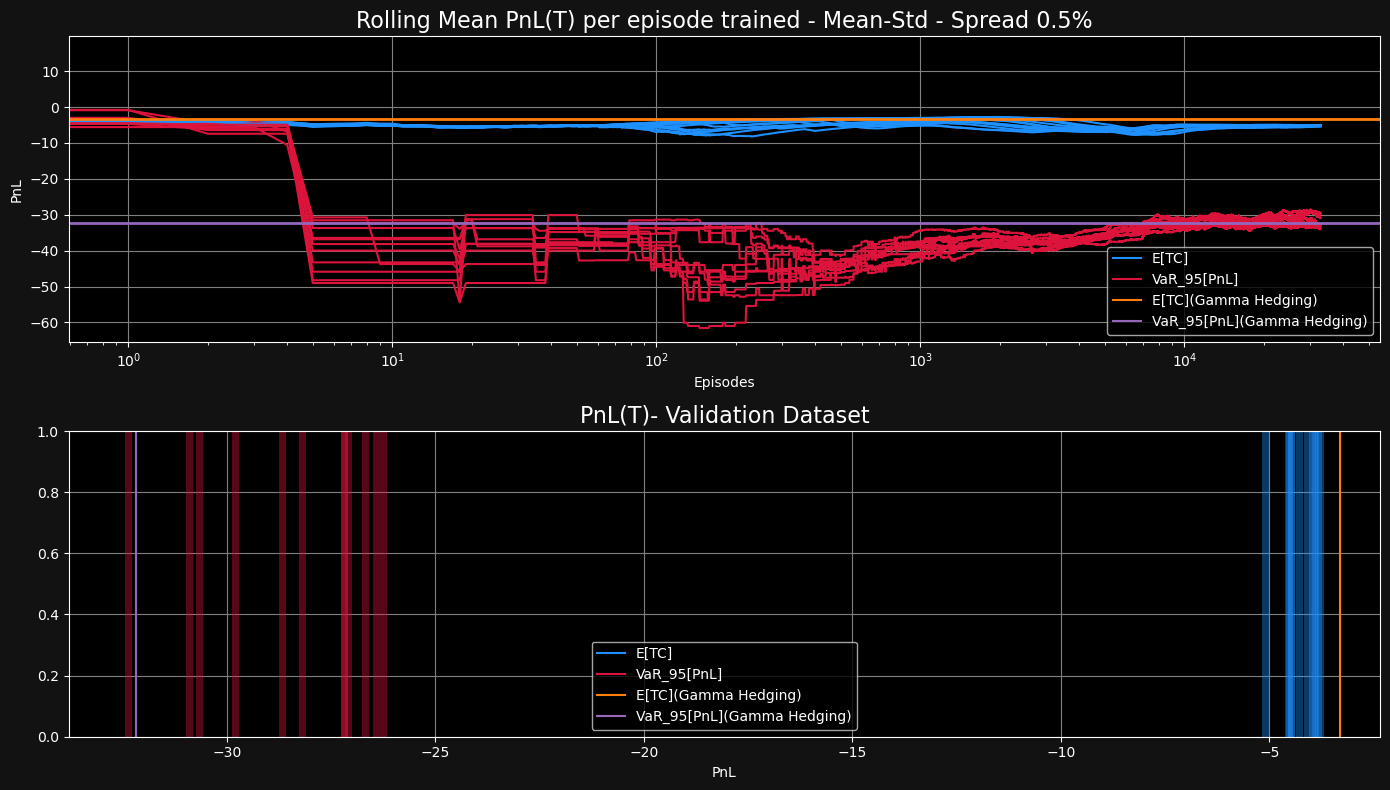

In [4]:
base_path = 'logs/(EXP 2) Heston Experiments/spread_05/Heston_Mean_Std_Batch/'
N_E = 12
batch_template_train = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):    
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - Mean-Std - Spread 0.5%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()

## Spread 0.5% - VaR

Heston Mean-Std 0.5%:0 pnl mean: -5.67 (±0.46) | std: 14.91112   | Mean-SD: -30.19 | gamma-ratio:  0.72( 0.13/ 1.18) | vega-ratio:  0.29( 0.11/ 0.47)| var95:   -30.87 | cvar95:   -43.61 | E[TC]: -5.30 (±0.08)
Heston Mean-Std 0.5%:1 pnl mean: -3.95 (±0.48) | std: 15.52960   | Mean-SD: -29.49 | gamma-ratio:  0.54( 0.16/ 0.93) | vega-ratio:  0.26( 0.08/ 0.44)| var95:   -28.44 | cvar95:   -42.21 | E[TC]: -4.18 (±0.05)
Heston Mean-Std 0.5%:2 pnl mean: -4.99 (±0.43) | std: 13.96647   | Mean-SD: -27.96 | gamma-ratio:  0.29( 0.01/ 0.60) | vega-ratio:  0.36( 0.18/ 0.51)| var95:   -27.71 | cvar95:   -39.22 | E[TC]: -3.99 (±0.03)
Heston Mean-Std 0.5%:3 pnl mean: -5.22 (±0.43) | std: 14.36010   | Mean-SD: -28.84 | gamma-ratio:  0.38( 0.05/ 0.75) | vega-ratio:  0.35( 0.14/ 0.55)| var95:   -28.38 | cvar95:   -40.79 | E[TC]: -4.37 (±0.04)
Heston Mean-Std 0.5%:4 pnl mean: -4.32 (±0.43) | std: 14.10094   | Mean-SD: -27.51 | gamma-ratio:  0.36( 0.02/ 0.65) | vega-ratio:  0.32( 0.12/ 0.48)| var95:   -27.

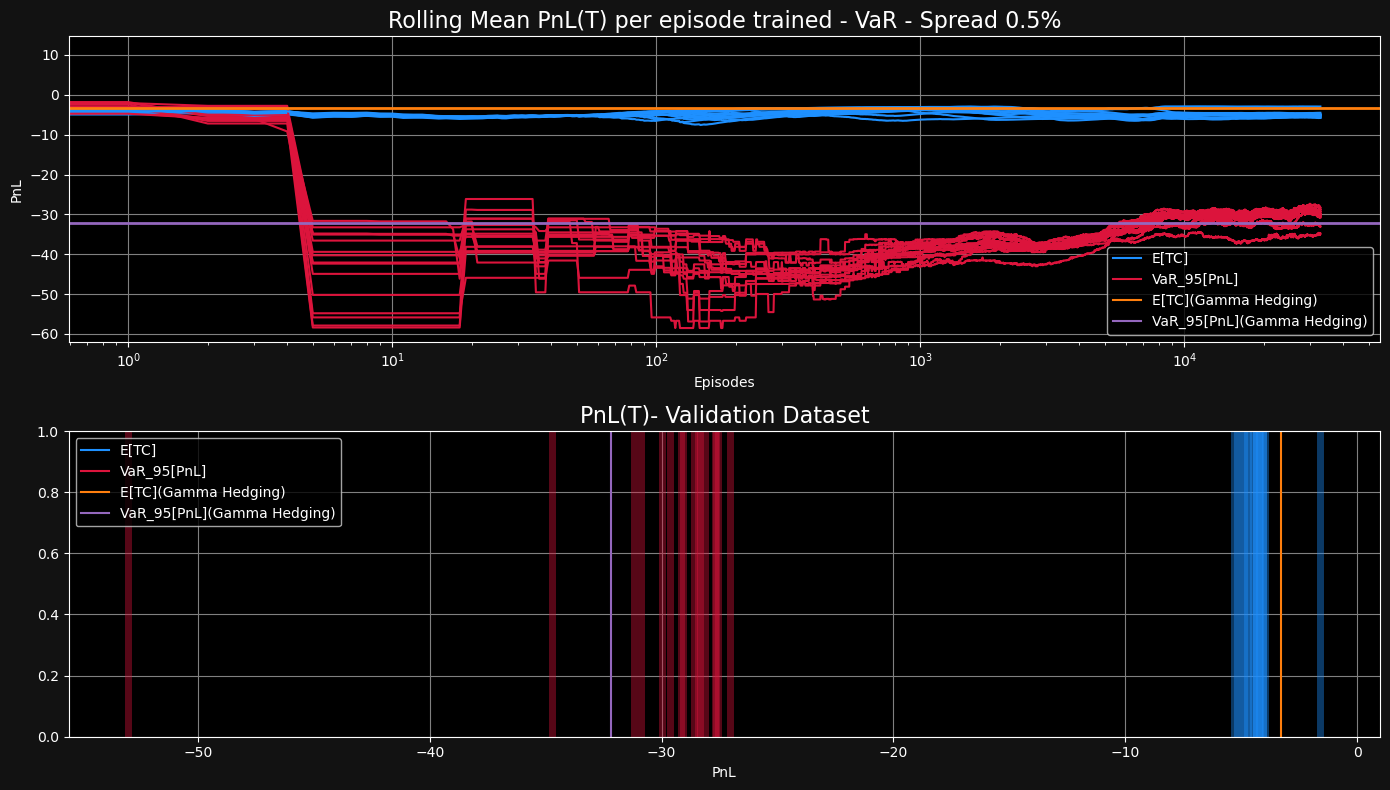

In [5]:
base_path = 'logs/(EXP 2) Heston Experiments/spread_05/Heston_VaR_Batch/'
N_E = 16
batch_template_train = (
    "Heston_VaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - VaR - Spread 0.5%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 0.5% - CVaR

Heston Mean-Std 0.5%:0 pnl mean: -4.83 (±0.45) | std: 14.84064   | Mean-SD: -29.24 | gamma-ratio:  0.40( 0.03/ 0.75) | vega-ratio:  0.37( 0.14/ 0.56)| var95:   -28.82 | cvar95:   -42.19 | E[TC]: -4.35 (±0.04)
Heston Mean-Std 0.5%:1 pnl mean: -4.45 (±0.43) | std: 14.03851   | Mean-SD: -27.54 | gamma-ratio:  0.52( 0.09/ 0.81) | vega-ratio:  0.29( 0.10/ 0.45)| var95:   -27.65 | cvar95:   -39.59 | E[TC]: -4.18 (±0.05)
Heston Mean-Std 0.5%:2 pnl mean: -4.75 (±0.58) | std: 18.60933   | Mean-SD: -35.36 | gamma-ratio:  0.41(-0.03/ 0.83) | vega-ratio:  0.44( 0.12/ 0.73)| var95:   -35.27 | cvar95:   -50.13 | E[TC]: -4.54 (±0.05)
Heston Mean-Std 0.5%:3 pnl mean: -4.89 (±0.44) | std: 14.44489   | Mean-SD: -28.65 | gamma-ratio:  0.37( 0.03/ 0.73) | vega-ratio:  0.35( 0.15/ 0.53)| var95:   -27.61 | cvar95:   -40.62 | E[TC]: -4.27 (±0.03)
Heston Mean-Std 0.5%:4 pnl mean: -5.17 (±0.57) | std: 18.68859   | Mean-SD: -35.92 | gamma-ratio:  0.28(-0.04/ 0.62) | vega-ratio:  0.42( 0.13/ 0.63)| var95:   -35.

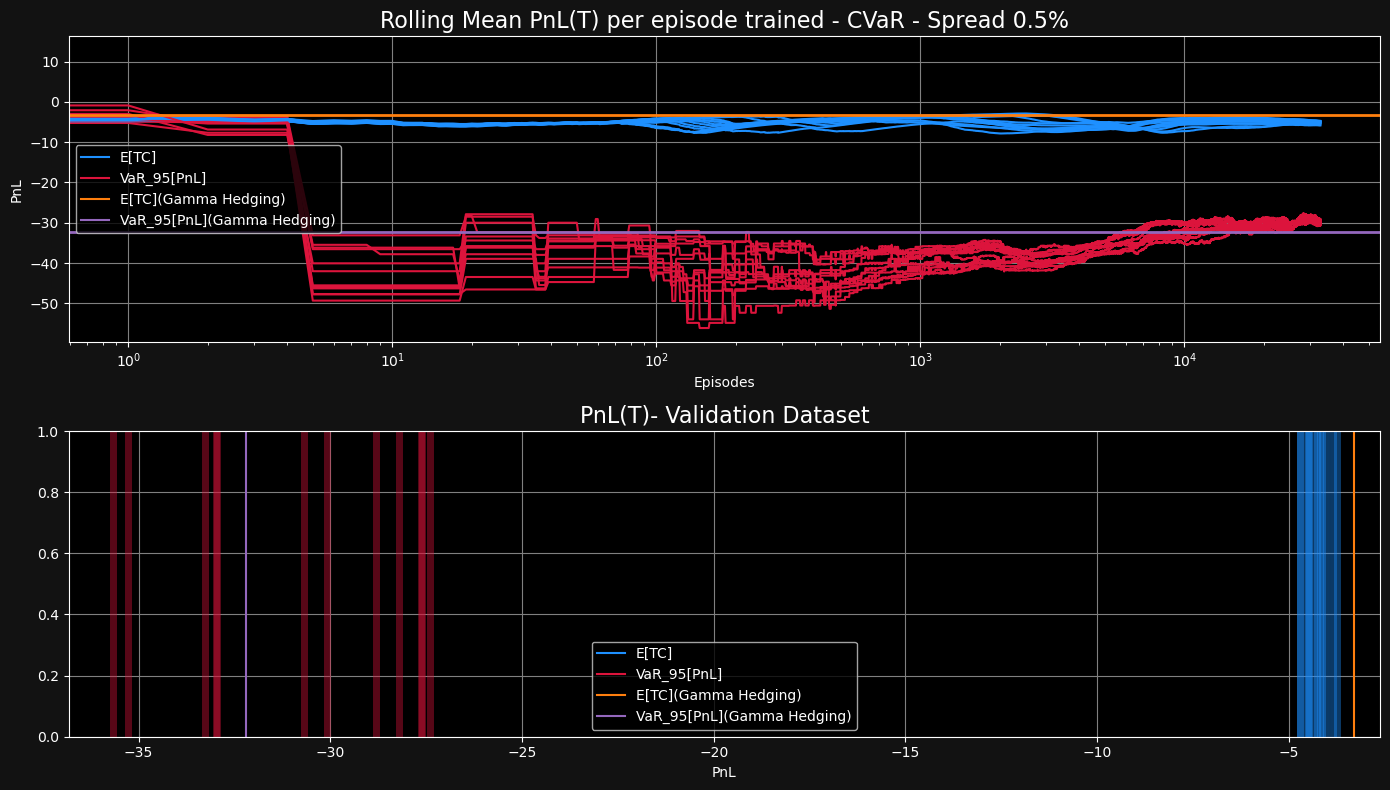

In [6]:
base_path = 'logs/(EXP 2) Heston Experiments/spread_05/Heston_CVaR_Batch/'
N_E = 12
batch_template_train = (
    "Heston_CVaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_CVaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_CVaR_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - CVaR - Spread 0.5%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 1% - Mean-Std

Heston Mean-Std 0.5%:0 pnl mean: -9.00 (±0.36) | std: 16.57392   | Mean-SD: -36.26 | gamma-ratio:  0.26 (-0.01/ 0.55) | vega-ratio:  0.30 ( 0.17/ 0.41)| var95:   -36.35 | cvar95:   -50.61 | E[TC]: -7.77 (±0.06)
Heston Mean-Std 0.5%:1 pnl mean: -9.36 (±0.35) | std: 16.51675   | Mean-SD: -36.53 | gamma-ratio:  0.25 (-0.01/ 0.54) | vega-ratio:  0.28 ( 0.13/ 0.41)| var95:   -36.45 | cvar95:   -49.72 | E[TC]: -6.85 (±0.04)
Heston Mean-Std 0.5%:2 pnl mean: -10.90(±0.36) | std: 16.59454   | Mean-SD: -38.20 | gamma-ratio:  0.36 ( 0.02/ 0.68) | vega-ratio:  0.23 ( 0.07/ 0.40)| var95:   -38.39 | cvar95:   -50.66 | E[TC]: -6.47 (±0.04)
Heston Mean-Std 0.5%:3 pnl mean: -10.61(±0.37) | std: 17.09254   | Mean-SD: -38.73 | gamma-ratio:  0.21 (-0.03/ 0.45) | vega-ratio:  0.24 ( 0.11/ 0.37)| var95:   -38.78 | cvar95:   -51.92 | E[TC]: -6.54 (±0.04)
Heston Mean-Std 0.5%:4 pnl mean: -10.92(±0.36) | std: 16.53796   | Mean-SD: -38.13 | gamma-ratio:  0.37 ( 0.02/ 0.66) | vega-ratio:  0.25 ( 0.08/ 0.41)| var

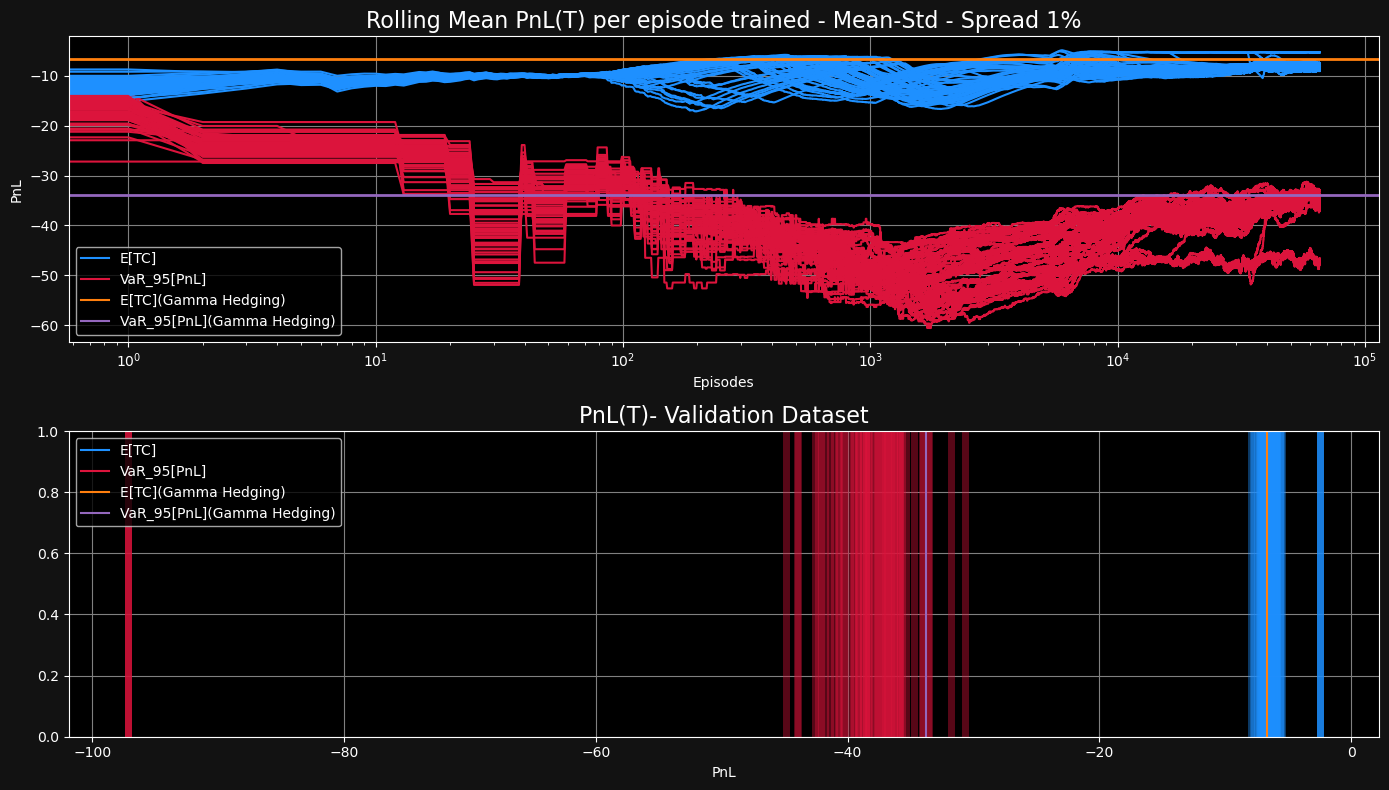

In [11]:
base_path = 'logs/(EXP 2.1) Heston Experiments/spread_1/Heston_Mean_Std_Batch/'
N_E = 60
batch_template_train = (
    "Heston_Mean_Std_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(0, N_E):
    df = (
        pl_read_csv(batch_folders_train[i])
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_samples=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_samples=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - Mean-Std - Spread 1%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2.1) Heston Experiments/spread_1/Heston_Gamma_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2.1) Heston Experiments/spread_1/Heston_Gamma_1/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 1% - VaR

Heston Mean-Std 0.5%:0 pnl mean: -9.24 (±0.36) | std: 16.57425   | Mean-SD: -36.51 | gamma-ratio:  0.38 ( 0.07/ 0.63) | vega-ratio:  0.19 ( 0.07/ 0.31)| var95:   -37.04 | cvar95:   -49.86 | E[TC]: -6.01 (±0.05)
Heston Mean-Std 0.5%:1 pnl mean: -11.49(±0.39) | std: 17.85287   | Mean-SD: -40.85 | gamma-ratio:  0.24 (-0.01/ 0.48) | vega-ratio:  0.17 ( 0.06/ 0.29)| var95:   -41.17 | cvar95:   -54.09 | E[TC]: -4.99 (±0.04)
Heston Mean-Std 0.5%:2 pnl mean: -10.89(±0.38) | std: 17.37952   | Mean-SD: -39.48 | gamma-ratio:  0.34 ( 0.07/ 0.61) | vega-ratio:  0.20 ( 0.06/ 0.36)| var95:   -40.14 | cvar95:   -53.05 | E[TC]: -6.72 (±0.06)
Heston Mean-Std 0.5%:3 pnl mean: -6.07 (±0.35) | std: 16.35545   | Mean-SD: -32.97 | gamma-ratio:  0.21 (-0.00/ 0.41) | vega-ratio:  0.23 ( 0.12/ 0.33)| var95:   -32.34 | cvar95:   -44.87 | E[TC]: -5.96 (±0.04)
Heston Mean-Std 0.5%:4 pnl mean: -10.87(±0.38) | std: 17.41031   | Mean-SD: -39.51 | gamma-ratio:  0.26 ( 0.01/ 0.47) | vega-ratio:  0.18 ( 0.06/ 0.31)| var

FileNotFoundError: No such file or directory (os error 2): ...a_1pct/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv

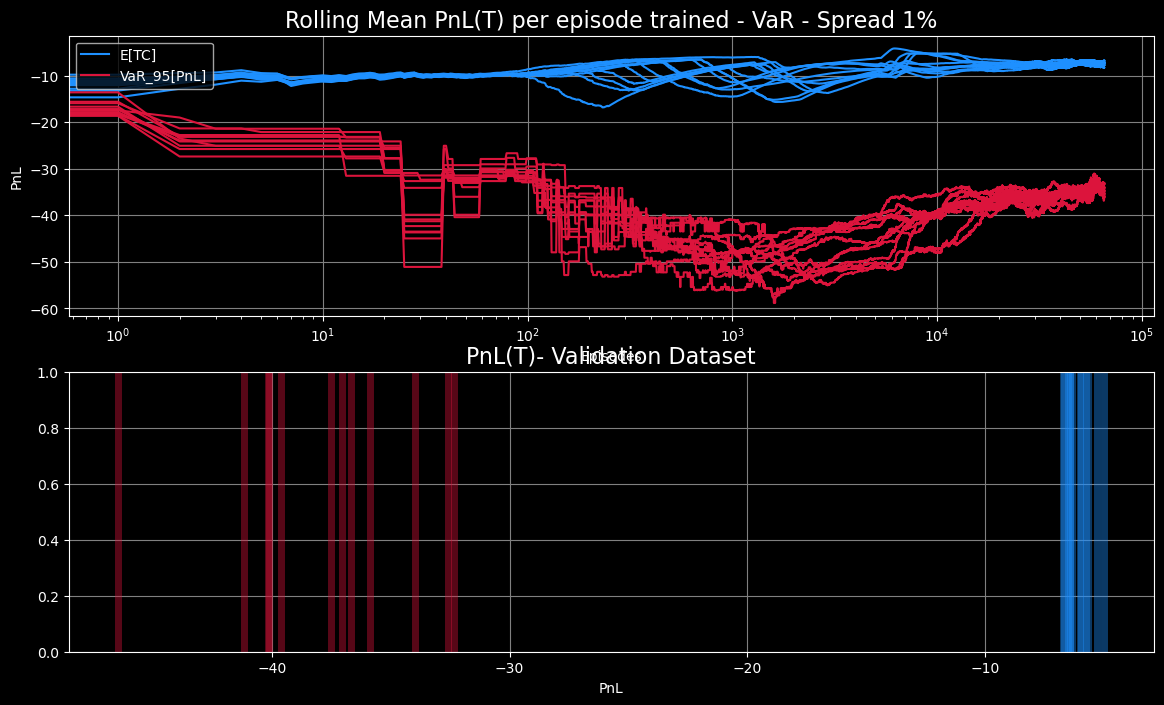

In [34]:
base_path = 'logs/(EXP 2.1) Heston Experiments/spread_1/Heston_VaR_Batch/'
N_E = 12
batch_template_train = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - VaR - Spread 1%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2.1) Heston Experiments/spread_1/Heston_Gamma_1pct/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2.1) Heston Experiments/spread_05/Heston_Gamma_1pct/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 1% - CVaR

NameError: name 'pl_read_csv' is not defined

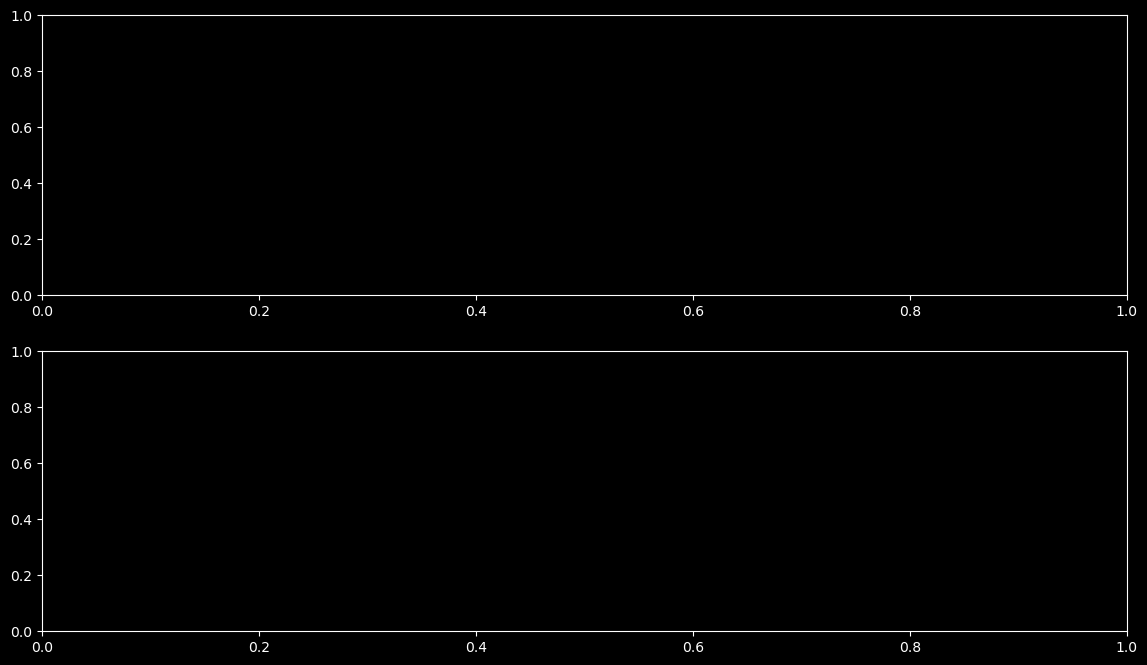

: 

: 

In [ ]:
base_path = 'logs/(EXP 2.1) Heston Experiments/spread_1/Heston_CVaR_Batch/'
N_E = 12
batch_template_train = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - CVaR - Spread 1%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2.1) Heston Experiments/spread_1/Heston_Gamma_1pct/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2.1) Heston Experiments/spread_05/Heston_Gamma_1pct/greekhedge_stochastic_process=Heston_spread=0.01_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 2% - Mean-Std

In [ ]:
base_path = 'logs/(EXP 2.1) Heston Experiments/spread_2/Heston_Mean_Std_Batch/'
N_E = 64
batch_template_train = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(2, N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=4)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - Mean-Std - Spread 2%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 2% - VaR

Heston Mean-Std 0.5%:0 pnl mean: -8.42 (±1.14) | std: 37.04520   | Mean-SD: -69.36 | gamma-ratio: -0.04(-0.10/ 0.00) | vega-ratio:  0.14( 0.00/ 0.39)| var95:   -69.41 | cvar95:   -98.58 | E[TC]: -5.14 (±0.15)
Heston Mean-Std 0.5%:1 pnl mean: -3.54 (±1.08) | std: 35.36314   | Mean-SD: -61.71 | gamma-ratio: -0.01(-0.07/ 0.03) | vega-ratio:  0.16( 0.01/ 0.42)| var95:   -56.44 | cvar95:   -77.58 | E[TC]: -6.22 (±0.15)
Heston Mean-Std 0.5%:2 pnl mean: -3.54 (±1.08) | std: 35.36314   | Mean-SD: -61.71 | gamma-ratio: -0.01(-0.07/ 0.03) | vega-ratio:  0.16( 0.01/ 0.42)| var95:   -56.44 | cvar95:   -77.58 | E[TC]: -6.22 (±0.15)
Heston Mean-Std 0.5%:3 pnl mean: -10.54(±0.50) | std: 16.26864   | Mean-SD: -37.31 | gamma-ratio:  0.36( 0.03/ 0.68) | vega-ratio:  0.18( 0.06/ 0.27)| var95:   -37.99 | cvar95:   -50.31 | E[TC]: -10.86(±0.10)
Heston Mean-Std 0.5%:4 pnl mean: -3.54 (±1.08) | std: 35.36314   | Mean-SD: -61.71 | gamma-ratio: -0.01(-0.07/ 0.03) | vega-ratio:  0.16( 0.01/ 0.42)| var95:   -56.

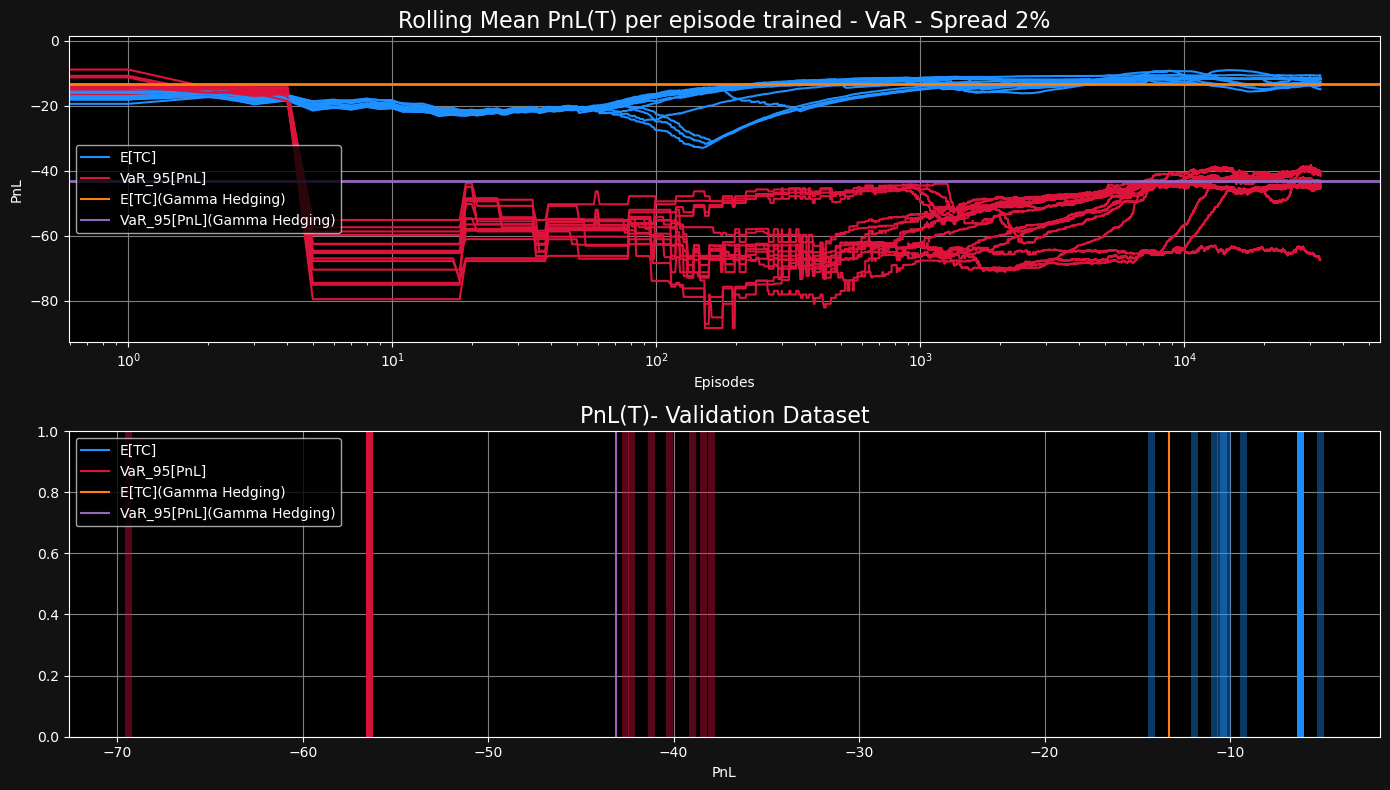

In [13]:
base_path = 'logs/(EXP 2) Heston Experiments/spread_2/Heston_VaR_Batch/'
N_E = 16
batch_template_train = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - VaR - Spread 2%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 2% - CVaR

Heston Mean-Std 0.5%:0 pnl mean: -16.11(±0.45) | std: 20.72205   | Mean-SD: -50.20 | gamma-ratio:  0.08 (-0.05/ 0.21) | vega-ratio:  0.16 ( 0.05/ 0.28)| var95:   -52.42 | cvar95:   -65.54 | E[TC]: -8.81 (±0.10)
Heston Mean-Std 0.5%:1 pnl mean: -11.72(±0.43) | std: 19.44550   | Mean-SD: -43.71 | gamma-ratio:  0.15 ( 0.01/ 0.29) | vega-ratio:  0.14 ( 0.06/ 0.23)| var95:   -42.13 | cvar95:   -54.36 | E[TC]: -8.29 (±0.06)
Heston Mean-Std 0.5%:2 pnl mean: -10.33(±0.40) | std: 18.40545   | Mean-SD: -40.61 | gamma-ratio:  0.21 ( 0.06/ 0.35) | vega-ratio:  0.13 ( 0.05/ 0.21)| var95:   -41.30 | cvar95:   -54.09 | E[TC]: -7.98 (±0.06)
Heston Mean-Std 0.5%:3 pnl mean: -11.96(±0.36) | std: 16.88330   | Mean-SD: -39.74 | gamma-ratio:  0.35 ( 0.18/ 0.53) | vega-ratio:  0.14 ( 0.05/ 0.27)| var95:   -41.06 | cvar95:   -52.80 | E[TC]: -10.27(±0.07)
Heston Mean-Std 0.5%:4 pnl mean: -9.24 (±0.36) | std: 16.46078   | Mean-SD: -36.32 | gamma-ratio:  0.22 ( 0.05/ 0.39) | vega-ratio:  0.16 ( 0.08/ 0.24)| var

FileNotFoundError: No such file or directory (os error 2): ...amma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv

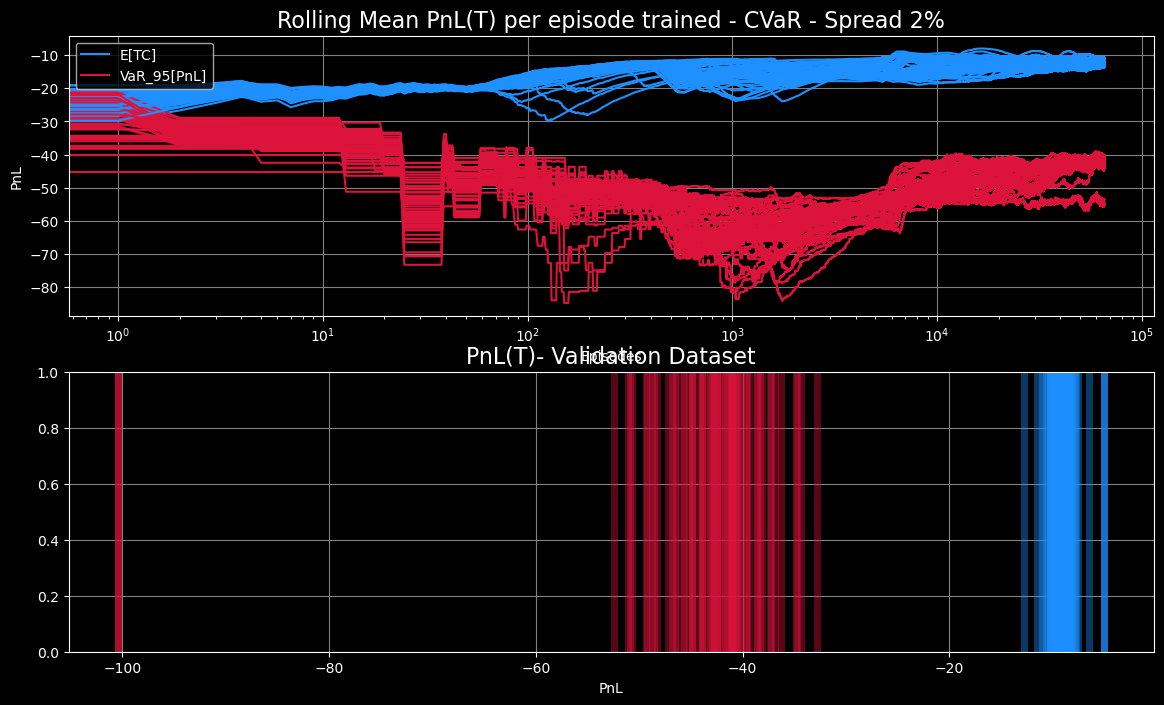

In [12]:
base_path = 'logs/(EXP 2.1) Heston Experiments/spread_2/Heston_CVaR_Batch/'
N_E = 64
batch_template_train = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=1)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - CVaR - Spread 2%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2.1) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2.1) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()


## Spread 2% - CVaR - 64k

Heston Mean-Std 0.5%:0 pnl mean: -16.11(±0.44) | std: 20.72205   | Mean-SD: -50.20 | gamma-ratio:  0.08 (-0.05/ 0.21) | vega-ratio:  0.16 ( 0.05/ 0.28)| var95:   -52.42 | cvar95:   -65.54 | E[TC]: -8.81 (±0.10)
Heston Mean-Std 0.5%:1 pnl mean: -11.72(±0.42) | std: 19.44550   | Mean-SD: -43.71 | gamma-ratio:  0.15 ( 0.01/ 0.29) | vega-ratio:  0.14 ( 0.06/ 0.23)| var95:   -42.13 | cvar95:   -54.36 | E[TC]: -8.29 (±0.06)
Heston Mean-Std 0.5%:2 pnl mean: -10.33(±0.40) | std: 18.40545   | Mean-SD: -40.61 | gamma-ratio:  0.21 ( 0.06/ 0.35) | vega-ratio:  0.13 ( 0.05/ 0.21)| var95:   -41.30 | cvar95:   -54.09 | E[TC]: -7.98 (±0.06)
Heston Mean-Std 0.5%:3 pnl mean: -11.96(±0.37) | std: 16.88330   | Mean-SD: -39.74 | gamma-ratio:  0.35 ( 0.18/ 0.53) | vega-ratio:  0.14 ( 0.05/ 0.27)| var95:   -41.06 | cvar95:   -52.80 | E[TC]: -10.27(±0.07)
Heston Mean-Std 0.5%:4 pnl mean: -9.24 (±0.36) | std: 16.46078   | Mean-SD: -36.32 | gamma-ratio:  0.22 ( 0.05/ 0.39) | vega-ratio:  0.16 ( 0.08/ 0.24)| var

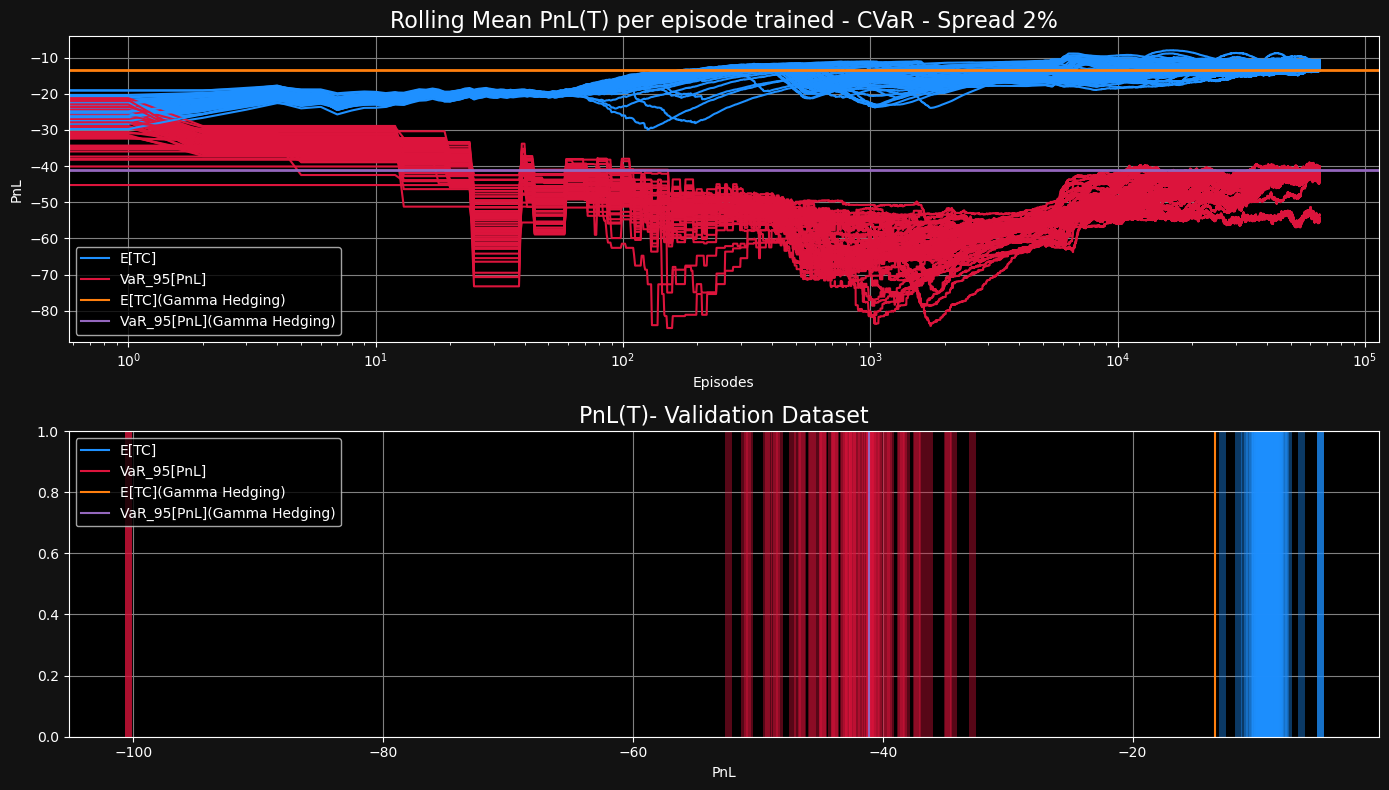

In [24]:
base_path = 'logs/(EXP 2.1) Heston Experiments/spread_2/Heston_CVaR_Batch/'
N_E = 64
batch_template_train = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_samples=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_samples=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - CVaR - Spread 2%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2.1) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2.1) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()

---------------------------------
# Heston European hedging option - Single

## Srpead 0.5% - Mean-Std

In [ ]:
base_path = 'logs/(EXP 2.2) Heston Experiments/spread_05/Heston_Mean_Std_Batch/'
N_E = 16
batch_template_train = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_05_{}/stochastic_process=Heston_spread=0.005_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

for i in range(N_E):    
    df = (
        pl_read_csv(batch_folders_train[i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    print(batch_folders_eval[i])
    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - Mean-Std - Spread 0.5%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2) Heston Experiments/spread_05/Heston_Gamma_05/greekhedge_stochastic_process=Heston_spread=0.005_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 0.5%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()

## Srpead 2% - Mean-Std

Heston Mean-Std 2%:0 pnl mean: -0.73 (±0.01) | std: 0.69342    | Mean-SD: -1.87  | gamma-ratio:  0.53 ( 0.34/ 0.70) | vega-ratio:  0.75 ( 0.57/ 0.86)| var95:    -1.57 | cvar95:    -2.19 | E[TC]: -0.94 (±0.01)
Heston Mean-Std 2%:1 pnl mean: -0.70 (±0.02) | std: 0.79433    | Mean-SD: -2.01  | gamma-ratio:  0.53 ( 0.34/ 0.70) | vega-ratio:  0.74 ( 0.55/ 0.86)| var95:    -1.54 | cvar95:    -2.14 | E[TC]: -0.92 (±0.00)
Heston Mean-Std 2%:2 pnl mean: -0.77 (±0.02) | std: 0.80349    | Mean-SD: -2.09  | gamma-ratio:  0.55 ( 0.40/ 0.70) | vega-ratio:  0.71 ( 0.58/ 0.81)| var95:    -1.61 | cvar95:    -2.71 | E[TC]: -0.96 (±0.01)
Heston Mean-Std 2%:3 pnl mean: -0.90 (±0.01) | std: 0.49160    | Mean-SD: -1.71  | gamma-ratio:  0.71 ( 0.55/ 0.83) | vega-ratio:  0.71 ( 0.60/ 0.82)| var95:    -1.64 | cvar95:    -1.91 | E[TC]: -0.99 (±0.00)
Heston Mean-Std 2%:4 pnl mean: -0.75 (±0.01) | std: 0.69000    | Mean-SD: -1.88  | gamma-ratio:  0.54 ( 0.36/ 0.70) | vega-ratio:  0.76 ( 0.58/ 0.87)| var95:    -1.

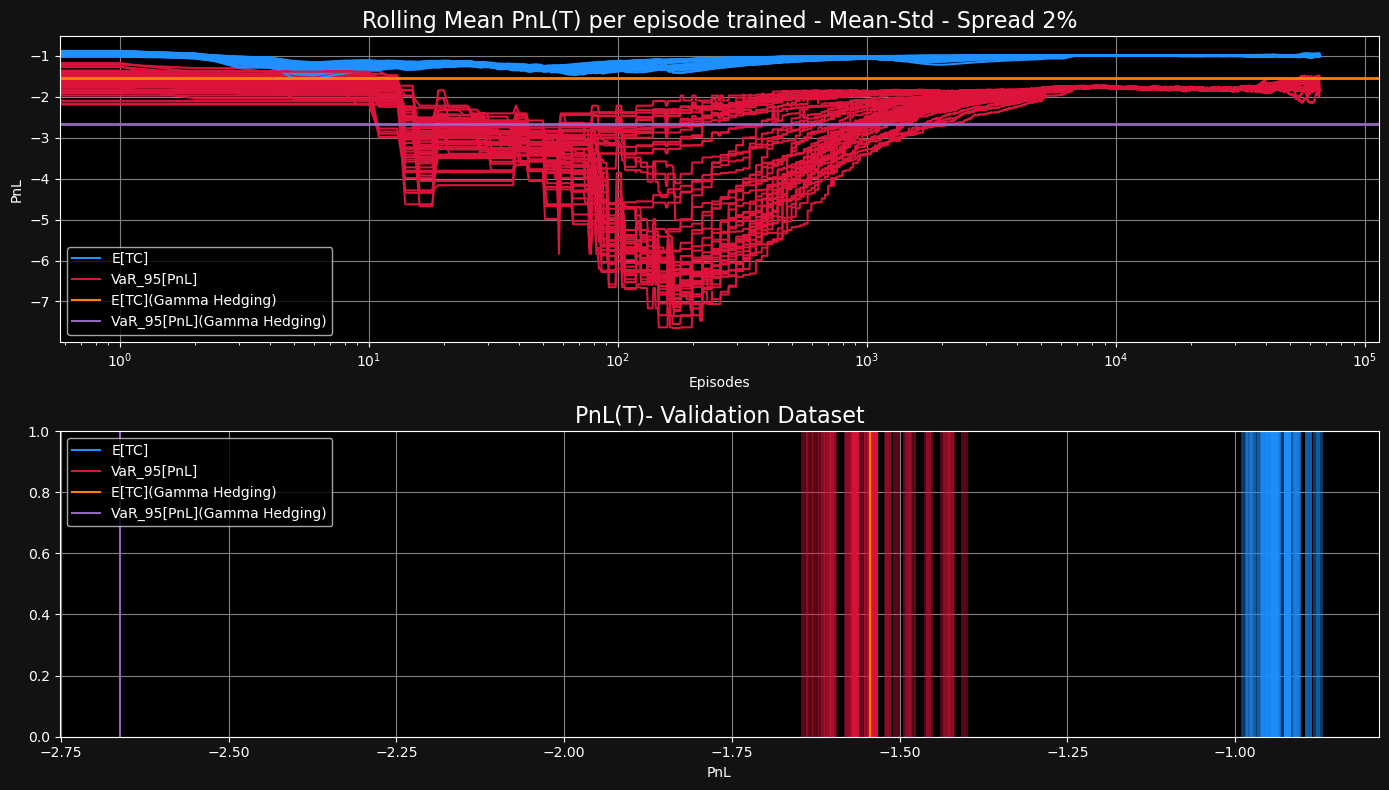

In [6]:
base_path = 'logs/(EXP 2.2) Heston Experiments/spread_2/Heston_Mean_Std_Batch/'
N_E = 64
batch_template_train = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

results_meanstd2 = {}
for i in range(N_E):    
    try:
        df = (
            pl_read_csv(batch_folders_train[1 if i == 0 else i], n_threads=16)
            .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
            .sort(['episode', 't'])
            .group_by('episode').agg(
                pl.col('step_pnl').sum().alias('step_pnl_sum'),
                pl.col('hed_cost').sum().alias('hed_cost_sum')
            )
            .with_columns([
                pl.col("hed_cost_sum").rolling_mean(
                    window_size=5_000, min_periods=0
                ).alias("mean_hc"),
                pl.col("step_pnl_sum").rolling_quantile(
                    quantile=0.05, window_size=5_000, min_periods=0
                ).alias("CVaR_95"),
            ])
            .to_pandas()
        )
        ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
        ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

        # print(batch_folders_eval[i])
        df = (
            pl_read_csv(batch_folders_eval[i], n_threads=16)
            .group_by('episode').agg(
                pl.col('step_pnl').sum().alias('step_pnl_sum'),
                pl.col('hed_cost').sum().alias('hed_cost_sum')
            )
            #mean hc and VaR 95 PnL
            .with_columns([
                pl.col("hed_cost_sum").mean().alias("mean_hc"),
                pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
            ])
            .to_pandas()
        )
        ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
        ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
        
        results_meanstd2[i] = generate_stat(batch_folders_eval[i], eval_quantiles, f'Heston Mean-Std 2%:{i}', return_resutls=True)
    except:
        pass


# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - Mean-Std - Spread 2%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2.2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2.2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 2%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()

## Srpead 2% - VaR

Heston VaR 2%:0      pnl mean: -0.70 (±0.02) | std: 0.79433    | Mean-SD: -2.01  | gamma-ratio:  0.53 ( 0.34/ 0.70) | vega-ratio:  0.74 ( 0.55/ 0.86)| var95:    -1.54 | cvar95:    -2.14 | E[TC]: -0.92 (±0.00)
Heston VaR 2%:1      pnl mean: -0.87 (±0.01) | std: 0.60179    | Mean-SD: -1.86  | gamma-ratio:  0.65 ( 0.42/ 0.84) | vega-ratio:  0.83 ( 0.72/ 0.91)| var95:    -1.60 | cvar95:    -2.19 | E[TC]: -0.99 (±0.01)
Heston VaR 2%:2      pnl mean: -0.73 (±0.02) | std: 0.69374    | Mean-SD: -1.87  | gamma-ratio:  0.53 ( 0.34/ 0.70) | vega-ratio:  0.75 ( 0.57/ 0.86)| var95:    -1.57 | cvar95:    -2.20 | E[TC]: -0.94 (±0.01)
Heston VaR 2%:3      pnl mean: -0.76 (±0.01) | std: 0.48772    | Mean-SD: -1.56  | gamma-ratio:  0.62 ( 0.41/ 0.80) | vega-ratio:  0.79 ( 0.70/ 0.88)| var95:    -1.44 | cvar95:    -1.65 | E[TC]: -0.90 (±0.00)
Heston VaR 2%:4      pnl mean: -0.73 (±0.01) | std: 0.68858    | Mean-SD: -1.86  | gamma-ratio:  0.54 ( 0.37/ 0.70) | vega-ratio:  0.75 ( 0.56/ 0.86)| var95:    -1.

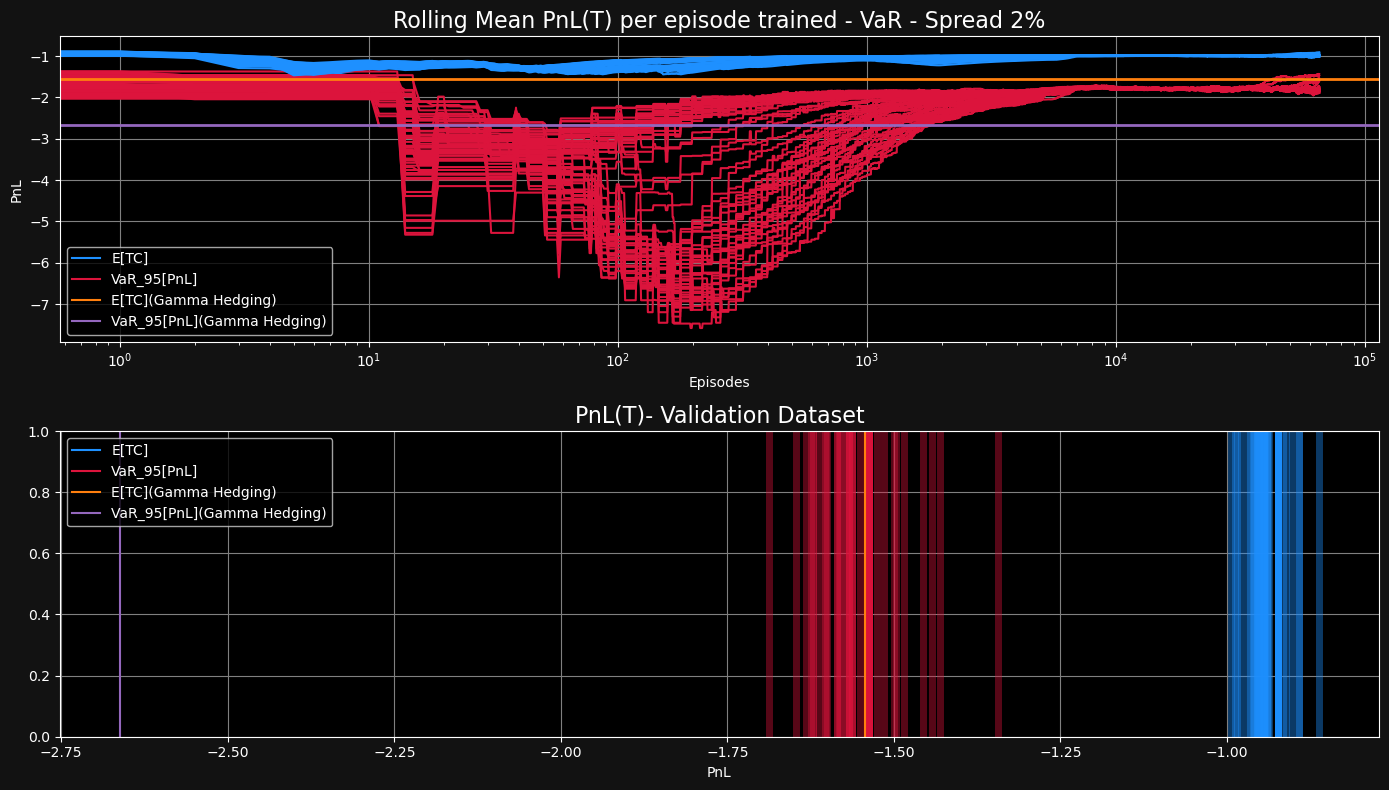

In [7]:
base_path = 'logs/(EXP 2.2) Heston Experiments/spread_2/Heston_VaR_Batch/'
N_E = 64
batch_template_train = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

results_var2 = {}
for i in range(N_E):    
    df = (
        pl_read_csv(batch_folders_train[1 if i == 0 else i], n_threads=16)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    # print(batch_folders_eval[i])
    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    results_var2[i] = generate_stat(batch_folders_eval[i], eval_quantiles, f'Heston VaR 2%:{i}', return_resutls=True)

# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - VaR - Spread 2%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2.2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2.2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 2%:{i}')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()

## Spread 2% - CVaR


Heston CVaR 2%:0     pnl mean: -0.70 (±0.02) | std: 0.79433    | Mean-SD: -2.01  | gamma-ratio:  0.53 ( 0.34/ 0.70) | vega-ratio:  0.74 ( 0.55/ 0.86)| var95:    -1.54 | cvar95:    -2.14 | E[TC]: -0.92 (±0.00)
Heston CVaR 2%:1     pnl mean: -0.70 (±0.02) | std: 0.79431    | Mean-SD: -2.01  | gamma-ratio:  0.53 ( 0.34/ 0.70) | vega-ratio:  0.74 ( 0.55/ 0.86)| var95:    -1.54 | cvar95:    -2.14 | E[TC]: -0.92 (±0.00)
Heston CVaR 2%:2     pnl mean: -0.94 (±0.01) | std: 0.48784    | Mean-SD: -1.74  | gamma-ratio:  0.74 ( 0.63/ 0.86) | vega-ratio:  0.72 ( 0.58/ 0.86)| var95:    -1.71 | cvar95:    -2.00 | E[TC]: -1.01 (±0.00)
Heston CVaR 2%:3     pnl mean: -0.70 (±0.02) | std: 0.79433    | Mean-SD: -2.01  | gamma-ratio:  0.53 ( 0.34/ 0.70) | vega-ratio:  0.74 ( 0.55/ 0.86)| var95:    -1.54 | cvar95:    -2.14 | E[TC]: -0.92 (±0.00)
Heston CVaR 2%:4     pnl mean: -0.76 (±0.01) | std: 0.65198    | Mean-SD: -1.84  | gamma-ratio:  0.54 ( 0.34/ 0.70) | vega-ratio:  0.76 ( 0.61/ 0.89)| var95:    -1.

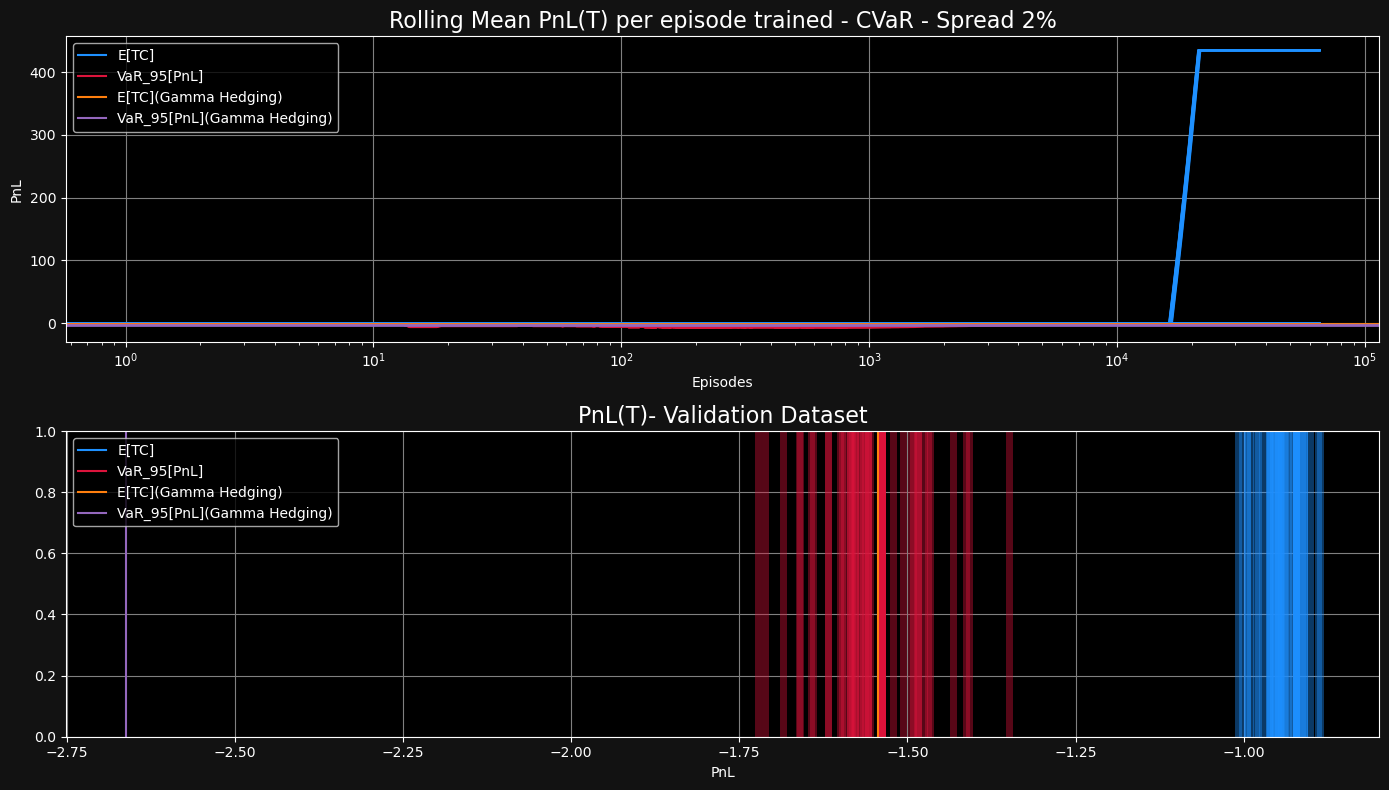

In [8]:
base_path = 'logs/(EXP 2.2) Heston Experiments/spread_2/Heston_CVaR_Batch/'
N_E = 64
batch_template_train = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

plt.style.use('dark_background')
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14, 8))

results_cvar2 = {}
for i in range(N_E):    
    df = (
        pl_read_csv(batch_folders_train[1 if i == 0 else i], n_threads=4)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .sort(['episode', 't'])
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").rolling_mean(
                window_size=5_000, min_periods=0
            ).alias("mean_hc"),
            pl.col("step_pnl_sum").rolling_quantile(
                quantile=0.05, window_size=5_000, min_periods=0
            ).alias("CVaR_95"),
        ])
        .to_pandas()
    )
    ax1.plot(df['episode'], df['mean_hc'], color='dodgerblue')
    ax1.plot(df['episode'], df['CVaR_95'], color='crimson')

    # print(batch_folders_eval[i])
    df = (
        pl_read_csv(batch_folders_eval[i], n_threads=16)
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        #mean hc and VaR 95 PnL
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
    ax2.axvline(x=df['mean_hc'].values[0], color='dodgerblue', label='mean_hc', linewidth=5, alpha=.4)
    ax2.axvline(x=df['VaR_95'].values[0], color='crimson', label='VaR_95', linewidth=5, alpha=.4)
    
    results_cvar2[i] = generate_stat(batch_folders_eval[i], eval_quantiles, f'Heston CVaR 2%:{i}', return_resutls=True)

# Ploting
ax1.set_title("Rolling Mean PnL(T) per episode trained - CVaR - Spread 2%", color='white', fontsize=16)
ax1.set_xlabel("Episodes", color='white')
ax1.set_ylabel("PnL", color='white')
ax1.set_xscale('log')
ax1.grid(True, color='gray')
ax1.tick_params(colors='white')
ax1.legend(['E[TC]', 'VaR_95[PnL]'], loc='upper left')

ax2.set_title("PnL(T)- Validation Dataset", color='white', fontsize=16)
ax2.set_xlabel("PnL", color='white')
ax2.grid(True, color='gray')
ax2.tick_params(colors='white')


# Gamma Hedge
df = (
        pl_read_csv('logs/(EXP 2.2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv')\
        .group_by('episode').agg(
            pl.col('step_pnl').sum().alias('step_pnl_sum'),
            pl.col('hed_cost').sum().alias('hed_cost_sum')
        )
        .with_columns([
            pl.col("hed_cost_sum").mean().alias("mean_hc"),
            pl.col("step_pnl_sum").quantile(0.05).alias("VaR_95"),
        ])
        .to_pandas()
    )
ax1.axhline(y=df['mean_hc'].mean(), color='tab:orange', label='mean_hc', linewidth=2)
ax1.axhline(y=df['VaR_95'].mean(), color='tab:purple', label='VaR_95', linewidth=2)
ax2.axvline(x=df['mean_hc'].mean(), color='tab:orange', label='mean_hc')
ax2.axvline(x=df['VaR_95'].mean(), color='tab:purple', label='VaR_95')
custom_lines = [mlines.Line2D([], [], color=color, label=label) for color, label in 
                zip(['dodgerblue', 'crimson', 'tab:orange', 'tab:purple'],
                    ['E[TC]', 'VaR_95[PnL]', 'E[TC](Gamma Hedging)', 'VaR_95[PnL](Gamma Hedging)'])]
ax1.legend(handles=custom_lines, loc='best')
ax2.legend(handles=custom_lines, loc='best')

generate_stat('logs/(EXP 2.2) Heston Experiments/spread_2/Heston_Gamma_2/greekhedge_stochastic_process=Heston_spread=0.02_hedttm=30/logs/eval_env/logs.csv',    eval_quantiles, f'Gamma 2%')

fig.patch.set_facecolor('#121212')
plt.tight_layout()
plt.show()

----------------------------
# Make 'obj function compare 2pct.csv'

In [9]:

df1 = pd.DataFrame.from_dict(results_cvar2, orient='index' , columns=['pnl mean',	'std', 'Mean-SD', 'gamma-ratio' , 'vega-ratio', 'var95', 'cvar95', 'E[TC]'])
df1['ObjFun'] = 'CVaR 2%'

df2 = pd.DataFrame.from_dict(results_var2, orient='index' , columns=['pnl mean',	'std', 'Mean-SD', 'gamma-ratio' , 'vega-ratio', 'var95', 'cvar95', 'E[TC]'])
df2['ObjFun'] = 'VaR 2%'

df3 = pd.DataFrame.from_dict(results_meanstd2, orient='index' , columns=['pnl mean',	'std', 'Mean-SD', 'gamma-ratio' , 'vega-ratio', 'var95', 'cvar95', 'E[TC]'])
df3['ObjFun'] = 'Mean-Std 2%'

df = pd.concat([df1, df2, df3])
df.set_index('ObjFun', inplace=True)
del df1, df2, df3

df.sort_values('pnl mean', ascending=False)

df.to_csv('obj function compare 2pct.csv')

# Trim the size of the train env folder

In [12]:
base_path = 'logs/(EXP 2.1) Heston Experiments/spread_1/Heston_CVaR_Batch/'
N_E = 20
batch_template_train = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)

batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

for i in trange(N_E):    
    # print(batch_folders_train[i])
    (
        pl.read_csv(batch_folders_train[i], n_threads=1)
        .select(pl.col('episode'), pl.col('t'), pl.col('step_pnl'), pl.col('hed_cost'))
        .write_csv(batch_folders_train[i])
    )    

# logs/(EXP 2.1) Heston Experiments/spread_1/Heston_Mean_Std_Batch/Heston_Mean_Std_1_1/stochastic_process=Heston_spread=0.01_obj=meanstd_threshold=0.95_critic=qr-huber_hedttm=30

100%|██████████| 20/20 [12:01<00:00, 36.08s/it]


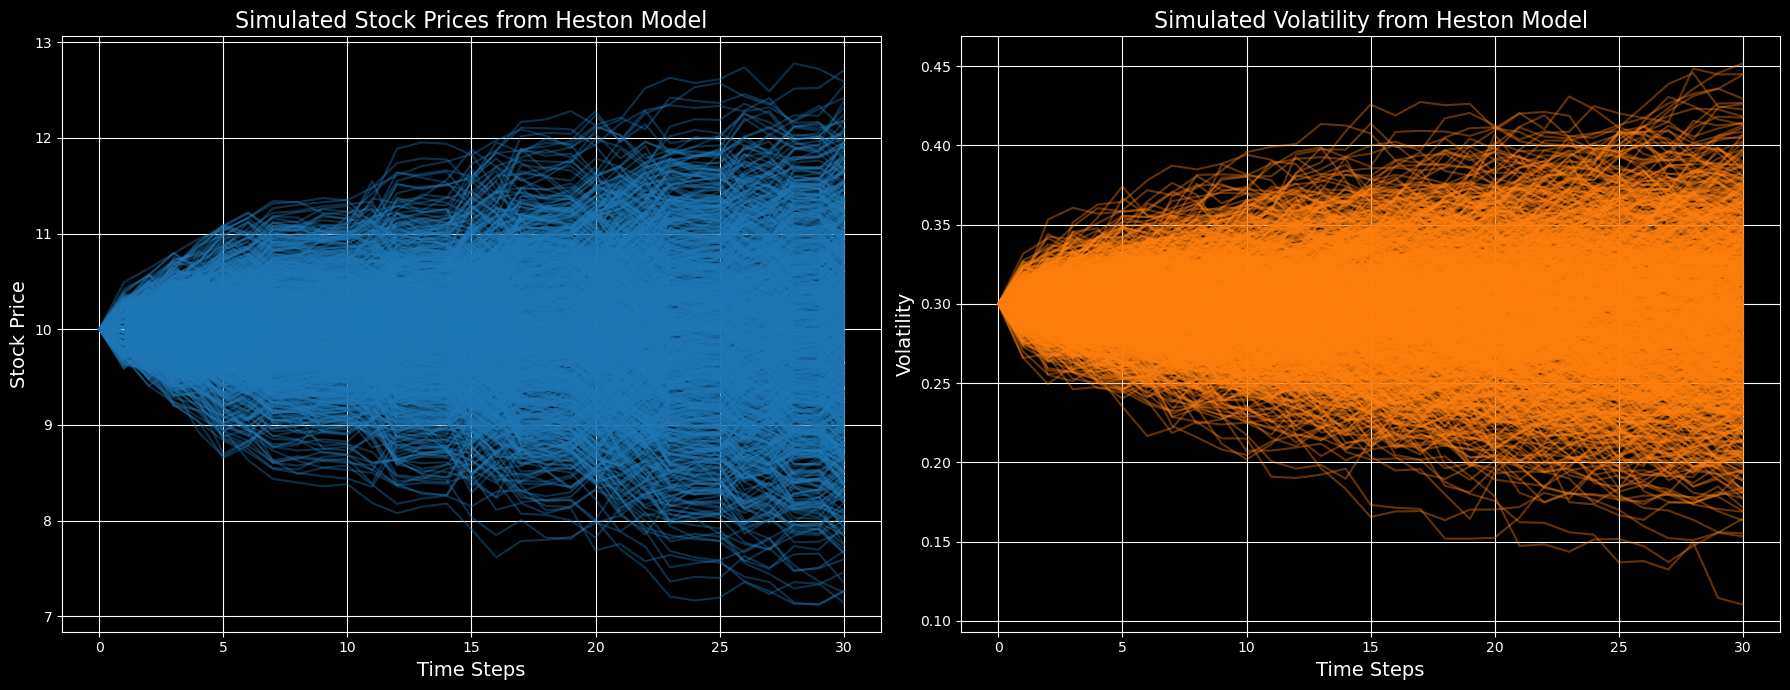

array([1.11022302e-16, 9.61750773e-03, 1.35881266e-02, 1.66182381e-02,
       1.91444692e-02, 2.13648874e-02, 2.33874117e-02, 2.52210949e-02,
       2.69164725e-02, 2.84814966e-02, 2.99837605e-02, 3.13983391e-02,
       3.27401787e-02, 3.40245229e-02, 3.52396323e-02, 3.64263200e-02,
       3.75415836e-02, 3.86421094e-02, 3.96918094e-02, 4.06993026e-02,
       4.16879306e-02, 4.26393668e-02, 4.35704873e-02, 4.44707178e-02,
       4.53388030e-02, 4.61682258e-02, 4.70011220e-02, 4.78140932e-02,
       4.86043128e-02, 4.93918524e-02, 5.01149118e-02])

In [74]:
import numpy as np
from scipy.stats import qmc
from tqdm import trange
import matplotlib.pyplot as plt

class HestonModel:
    def __init__(self, S0, V0, rho, theta, sigma, kappa, r, q, dt, T_steps, N_paths, seed=None):
        """
        Initializes the Heston Model with the provided parameters.
        
        Parameters
        ----------
        S0 : float
            Initial stock price.
        V0 : float
            Initial variance (V0 = volatility^2).
        rho : float
            Correlation between the two Brownian motions.
        theta : float
            Long-term mean of the variance.
        sigma : float
            Volatility of the variance process (vol of vol).
        kappa : float
            Rate at which variance reverts to theta.
        r : float
            Risk-free interest rate.
        q : float
            Dividend yield.
        dt : float
            Time increment.
        T_steps : int
            Number of time steps.
        N_paths : int
            Number of simulated paths.
        seed : int, optional
            Random seed for reproducibility (default is None).
        """
        self.S0 = S0
        self.init_vol = np.sqrt(V0)
        self.r = r
        self.q = q
        self.kappa = kappa
        self.theta = theta
        self.volvol = sigma
        self.rho = rho
        self.num_sim = N_paths
        self.num_period = T_steps
        self.dt = dt
        self.seed = seed if seed is not None else np.random.randint(0, 100000)
    
    def get_sim_path_Heston(self, psiC=1.5, gamma1=0.5, gamma2=0.5, Martingale_Correction=True, _show_progress=True):
        """
        Simulates the Heston model using the Quadratic Exponential (QE) scheme with dynamic volatility of volatility.
        
        Parameters
        ----------
        psiC : float, optional
            Threshold parameter for the QE scheme (default is 1.5).
        gamma1 : float, optional
            Gamma parameter for the QE scheme (default is 0.5).
        gamma2 : float, optional
            Gamma parameter for the QE scheme (default is 0.5).
        Martingale_Correction : bool, optional
            If True, applies Martingale correction (default is True).
        _show_progress : bool, optional
            If True, displays progress of the simulation (default is True).
        
        Returns
        -------
        S : ndarray
            Simulated stock prices, shape (N_paths, T_steps+1).
        V : ndarray
            Simulated volatility, shape (N_paths, T_steps+1). - Square Rooted Variances
        """
        # Define local parameters from global parameters
        S0 = self.S0
        V0 = self.init_vol**2
        r = self.r
        q = self.q
        kappa = self.kappa
        theta = self.theta
        xi_initial = self.volvol  # Renamed for clarity
        rho = self.rho
        N_paths = self.num_sim
        T_steps = self.num_period
        dt = self.dt

        E = np.exp(-kappa * dt)

        # Initialize xi as an array to store xi for each time step and path
        xi = np.full((T_steps + 1, N_paths), xi_initial)

        if Martingale_Correction:
            K0_star = np.empty(N_paths)

        # Initialize Sobol sequence generator
        sobol_gen = qmc.Sobol(d=T_steps + 1, scramble=True, seed=self.seed)
        # Generate two sets of uniform random numbers for variance and stock processes
        Uv = sobol_gen.random(n=N_paths).T
        Us = sobol_gen.random(n=N_paths).T
        Zv, Zs = stats.norm.ppf(Uv), stats.norm.ppf(Us)

        # Initialize stock price and variance arrays
        S = np.zeros((T_steps + 1, N_paths))
        V = np.zeros((T_steps + 1, N_paths))

        S[0] = np.log(S0)
        V[0] = V0

        for t in trange(1, T_steps + 1, desc="Generating Paths", position=0, leave=False, disable=not _show_progress):
            # Update xi for each path with a random perturbation
            xi[t] = xi[t] * np.random.normal(1, 0.2, size=N_paths)

            # Compute parameters K0, K1, K2, K3, K4 using the updated xi
            K0 = -(kappa * rho * theta) / xi[t] * dt
            K1 = (kappa * rho / xi[t] - 0.5) * gamma1 * dt - rho / xi[t]
            K2 = (kappa * rho / xi[t] - 0.5) * gamma2 * dt + rho / xi[t]
            K3 = (1 - rho ** 2) * gamma1 * dt  # Scalar
            K4 = (1 - rho ** 2) * gamma2 * dt  # Scalar
            A = K2 + 0.5 * K4

            # Calculate the mean and variance for the variance process
            m = theta + (V[t - 1] - theta) * E
            s2 = (V[t - 1] * xi[t]**2 * E) / kappa * (1 - E) + (theta * xi[t]**2) / (2 * kappa) * (1 - E)**2
            psi = s2 / m ** 2

            # Determine which paths use the quadratic and exponential schemes
            idx = psi <= psiC

            # Quadratic scheme for psi <= psiC
            b = np.sqrt(2 / psi[idx] - 1 + np.sqrt(2 / psi[idx] * (2 / psi[idx] - 1)))
            a = m[idx] / (1 + b**2)
            V[t, idx] = a * (b + Zv[t, idx]) ** 2

            # Exponential scheme for psi > psiC
            p = (psi[~idx] - 1) / (psi[~idx] + 1)
            beta = (1 - p) / m[~idx]
            idx2 = (Uv[t, ~idx] <= p)
            V[t, ~idx] = np.where(idx2, 0, 1 / beta * np.log((1 - p) / (1 - Uv[t, ~idx])))

            if Martingale_Correction:
                K0_star[idx]  = - (A[idx] * b**2 * a) / (1 - 2 * A[idx] * a) + 0.5 * np.log(1 - 2 * A[idx] * a) - (K1[idx] + 0.5 * K3) * V[t - 1, idx]  # Removed indexing on K3
                K0_star[~idx] = - np.log(p + (beta * (1 - p)) / (beta - A[~idx])) - (K1[~idx] + 0.5 * K3) * V[t - 1, ~idx]  # Removed indexing on K3
                # K0_star[idx]  = - (A * b**2 * a) / (1 - 2 * A * a) + 0.5 * np.log(1 - 2 * A * a) - (K1 + 0.5 * K3) * V[t-1, idx]
                # K0_star[~idx] = - np.log(p + (beta * (1 - p)) / (beta - A)) - (K1 + 0.5 * K3) * V[t-1, ~idx]

                S[t] = S[t - 1] + (r - q)*dt + K0_star + K1*V[t - 1] + K2*V[t] + np.sqrt(K3*V[t - 1] + K4*V[t])*Zs[t]
            else:
                S[t] = S[t - 1] + (r - q)*dt + K0      + K1*V[t - 1] + K2*V[t] + np.sqrt(K3*V[t - 1] + K4*V[t])*Zs[t]

        # Exponentiate the log stock prices to get actual stock prices
        S = np.exp(S).T
        V = np.sqrt(V).T

        # Handle any NaN values by replacing affected paths with deterministic paths
        idx_valid = np.isnan(S).sum(axis=1) == 0
        if idx_valid.sum() < N_paths:
            print(f"Warning: {N_paths - idx_valid.sum()} paths removed due to NaN values and replaced with deterministic paths.")
            time_grid = np.arange(T_steps + 1) * dt
            deterministic_S = S0 * np.exp((r - q) * time_grid)
            deterministic_V = self.init_vol * np.exp(-kappa * time_grid) + np.sqrt(theta) * (1 - np.exp(-kappa * time_grid))
            S[~idx_valid] = deterministic_S
            V[~idx_valid] = deterministic_V

        return S, V


# Example Parameters
S0 = 10          # Initial stock price
V0 = 0.09         # Initial variance (i.e., initial volatility = sqrt(0.04) = 0.2)
rho = -0.7        # Correlation between stock and variance
theta = 0.09      # Long-term variance mean
sigma = 0.3       # Volatility of volatility
kappa = 1.0       # Rate of mean reversion
r = 0.00          # Risk-free rate
q = 0.00          # Dividend yield
dt = 1/252        # Time increment (daily steps)
T_steps = 30     # Number of time steps (1 trading year)
N_paths = 1024*64   # Number of simulated paths
seed = 42         # Random seed for reproducibility

# Instantiate the Heston Model
heston = HestonModel(S0=S0, V0=V0, rho=rho, theta=theta, sigma=sigma, 
                    kappa=kappa, r=r, q=q, dt=dt, T_steps=T_steps, 
                    N_paths=N_paths, seed=seed)

# Run the Heston Model Simulation
S_simulated, V_simulated = heston.get_sim_path_Heston(_show_progress=True)

# Plot the S_simulated and V_simulated in a 2 column figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot simulated stock prices
ax1.plot(S_simulated[:1000].T, lw=1.5, c='tab:blue', alpha=.4)
ax1.set_title("Simulated Stock Prices from Heston Model", fontsize=16)
ax1.set_xlabel("Time Steps", fontsize=14)
ax1.set_ylabel("Stock Price", fontsize=14)
ax1.grid(True)

# Plot simulated volatility
ax2.plot(V_simulated[:1000].T, lw=1.5, c='tab:orange', alpha=.4)
ax2.set_title("Simulated Volatility from Heston Model", fontsize=16)
ax2.set_xlabel("Time Steps", fontsize=14)
ax2.set_ylabel("Volatility", fontsize=14)
ax2.grid(True)



plt.tight_layout()
plt.show()


V_simulated.std(axis=0)

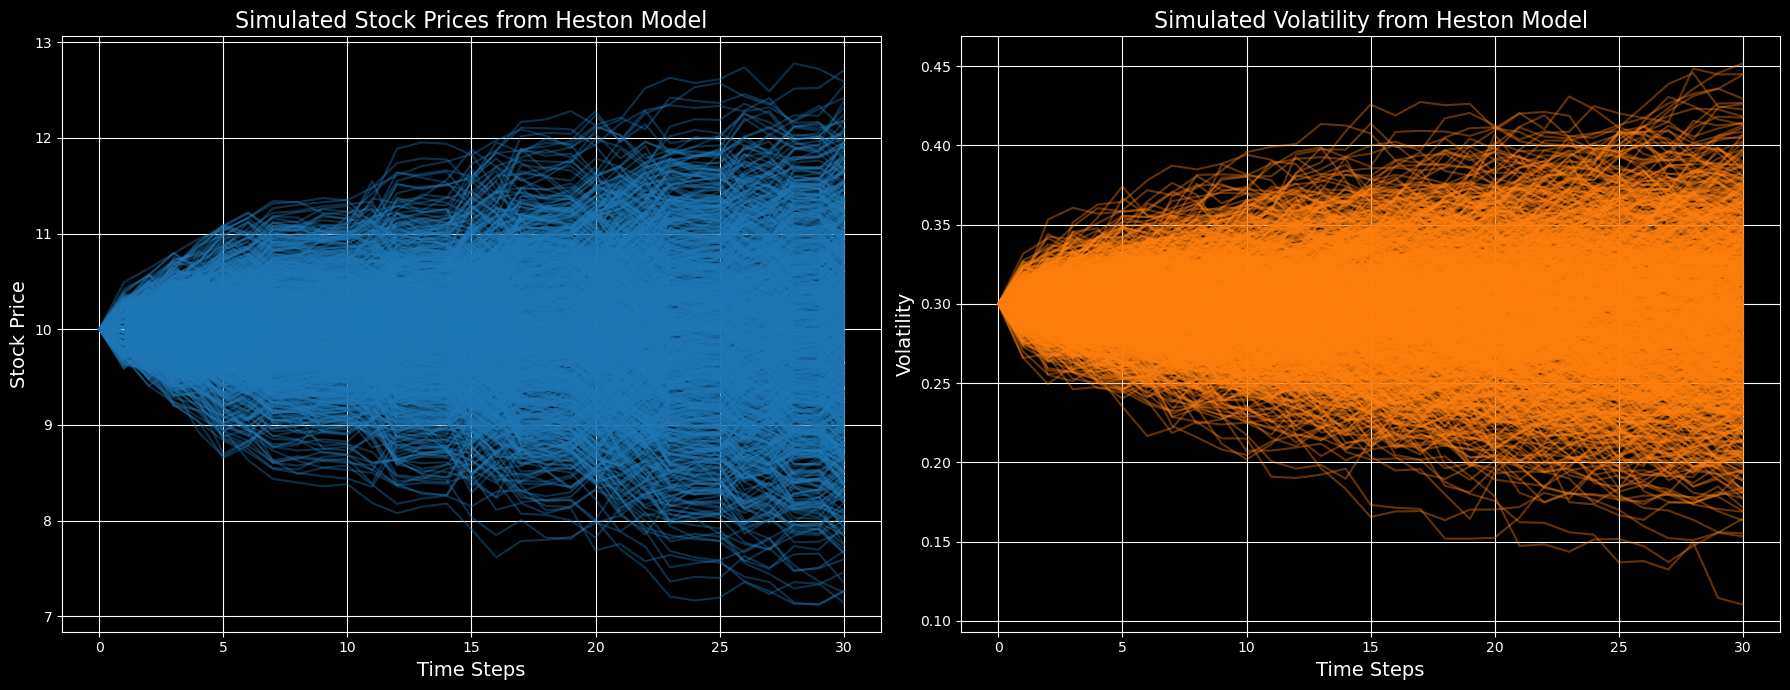

In [75]:
from environment.utilsAlexander import Utils

# Example Parameters
S0 = 10          # Initial stock price
V0 = 0.3         # Initial variance (i.e., initial volatility = sqrt(0.04) = 0.2)
rho = -0.7        # Correlation between stock and variance
theta = 0.09      # Long-term variance mean
sigma = 0.3       # Volatility of volatility
kappa = 1.0       # Rate of mean reversion
r = 0.00          # Risk-free rate
q = 0.00          # Dividend yield
dt = 1/252        # Time increment (daily steps)
T_steps = 252     # Number of time steps (1 trading year)
N_paths = 2**12   # Number of simulated paths
seed = 42         # Random seed for reproducibility

utils = Utils(
    # Liability Portfolio Parameters
    S0=10, K=10, init_ttm=30, r=0.00, q=0.00, spread=0.02,
    ttms=[60], poisson_rate=0.0, 
    
    # Hedging Portfolio Parameters
    hed_ttm=30, hed_type='European',

    # init_vol is for both GBM and Heston
    init_vol=0.3,
    # Heston, Model Parameters
    kappa=1, theta=0.09, volvol=0.3, rho=-0.7,
    
    # Simulation Parameters
    stochastic_process='Heston', time_to_simulate=30, num_sim=1024*64, frq=1,
    numerical_accuracy="high", n_jobs=1, np_seed=1235,

    # RL Environment Parameters
    action_low=0, action_high=3,
)


# Run the Heston Model Simulation
S_simulated_og, V_simulated_og = utils.get_sim_path_Heston(_show_progress=True)

# Plot the S_simulated and V_simulated in a 2 column figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot simulated stock prices
ax1.plot(S_simulated[:1000].T, lw=1.5, c='tab:blue', alpha=.4)
ax1.set_title("Simulated Stock Prices from Heston Model", fontsize=16)
ax1.set_xlabel("Time Steps", fontsize=14)
ax1.set_ylabel("Stock Price", fontsize=14)
ax1.grid(True)

# Plot simulated volatility
ax2.plot(V_simulated[:1000].T, lw=1.5, c='tab:orange', alpha=.4)
ax2.set_title("Simulated Volatility from Heston Model", fontsize=16)
ax2.set_xlabel("Time Steps", fontsize=14)
ax2.set_ylabel("Volatility", fontsize=14)
ax2.grid(True)


plt.tight_layout()
plt.show()

S_og   V_og      S      V
0  0.0000 0.0000 0.0000 0.0000
1  0.1398 0.0094 0.1537 0.0096
2  0.2057 0.0133 0.2154 0.0136
3  0.3020 0.0163 0.3087 0.0166
4  0.3303 0.0188 0.3436 0.0191
5  0.4136 0.0209 0.4138 0.0214
6  0.4416 0.0229 0.4354 0.0234
7  0.4918 0.0247 0.4881 0.0252
8  0.4948 0.0264 0.4916 0.0269
9  0.5034 0.0279 0.5004 0.0285
10 0.5069 0.0294 0.5033 0.0300
11 0.5299 0.0307 0.5261 0.0314
12 0.5869 0.0321 0.5868 0.0327
13 0.5943 0.0333 0.5933 0.0340
14 0.5973 0.0345 0.5963 0.0352
15 0.6388 0.0356 0.6473 0.0364
16 0.6894 0.0368 0.6834 0.0375
17 0.7225 0.0378 0.7319 0.0386
18 0.7286 0.0388 0.7381 0.0397
19 0.7346 0.0398 0.7443 0.0407
20 0.7684 0.0408 0.7748 0.0417
21 0.7987 0.0417 0.8132 0.0426
22 0.8304 0.0426 0.8417 0.0436
23 0.8672 0.0435 0.8770 0.0445
24 0.8717 0.0444 0.8811 0.0453
25 0.8736 0.0452 0.8833 0.0462
26 0.9076 0.0460 0.9119 0.0470
27 0.9199 0.0468 0.9226 0.0478
28 0.9466 0.0476 0.9491 0.0486
29 0.9488 0.0483 0.9513 0.0494
30 0.9802 0.0491 0.9779 0.0501

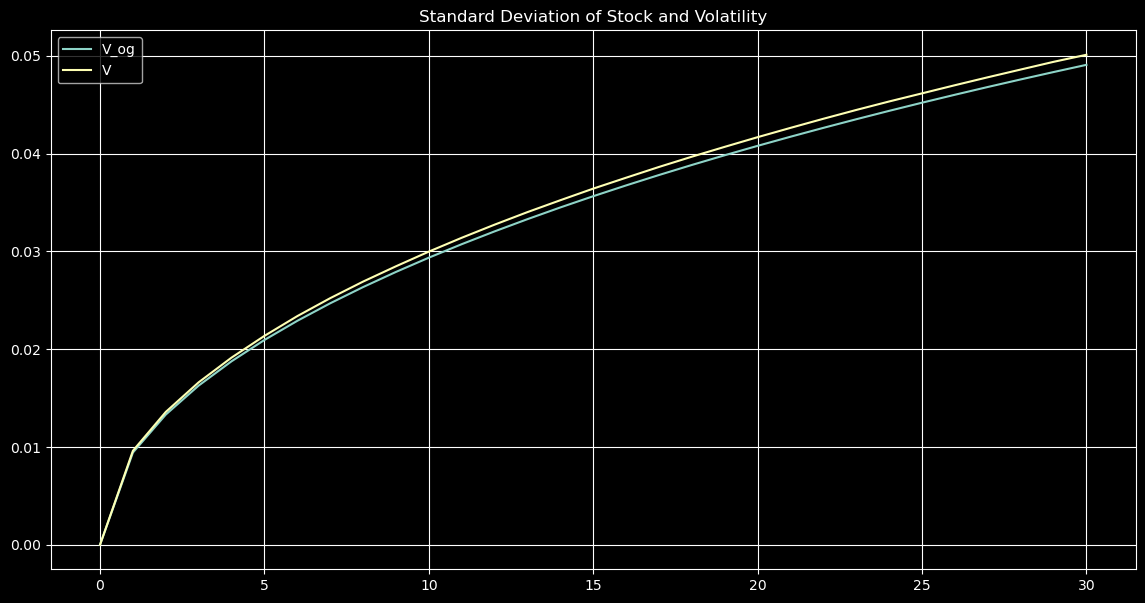

In [76]:
df = {'S_og': S_simulated_og.std(axis=0), 'V_og': V_simulated_og.std(axis=0), 'S': S_simulated.std(axis=0), 'V': V_simulated.std(axis=0)}
df = pd.DataFrame(df)
pd.options.display.float_format = '{:.4f}'.format

df[['V_og', 'V']].plot(figsize=(14, 7), title='Standard Deviation of Stock and Volatility', grid=True)  # [['V_og', 'V']]
df

# Rho -0.1

In [8]:
base_path = 'logs/(EXP 3.1) ST Heston Experiments (rho-0.1)/spread_1/Heston_VaR_Batch/'

N_E = 60
batch_template_train = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

for i in range(40):
    try:
        generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')
    except:
        pass


Heston Mean-Std 0.5%:0 pnl mean: -9.71 (±0.37) | std: 17.01777   | Mean-SD: -37.70 | gamma-ratio:  0.26 (-0.01/ 0.55) | vega-ratio:  0.30 ( 0.14/ 0.45)| var95:   -37.01 | cvar95:   -50.21 | E[TC]: -7.25 (±0.04)
Heston Mean-Std 0.5%:9 pnl mean: -11.35(±0.37) | std: 17.11253   | Mean-SD: -39.50 | gamma-ratio:  0.29 (-0.02/ 0.60) | vega-ratio:  0.19 ( 0.07/ 0.34)| var95:   -39.99 | cvar95:   -52.50 | E[TC]: -6.27 (±0.05)
Heston Mean-Std 0.5%:20 pnl mean: -10.52(±0.35) | std: 16.23378   | Mean-SD: -37.22 | gamma-ratio:  0.44 ( 0.07/ 0.73) | vega-ratio:  0.22 ( 0.07/ 0.40)| var95:   -37.72 | cvar95:   -49.84 | E[TC]: -6.62 (±0.04)
Heston Mean-Std 0.5%:21 pnl mean: -7.19 (±0.34) | std: 15.82996   | Mean-SD: -33.23 | gamma-ratio:  0.32 ( 0.02/ 0.58) | vega-ratio:  0.23 ( 0.12/ 0.35)| var95:   -32.47 | cvar95:   -44.97 | E[TC]: -6.33 (±0.04)
Heston Mean-Std 0.5%:22 pnl mean: -6.47 (±0.36) | std: 16.59618   | Mean-SD: -33.78 | gamma-ratio:  0.29 ( 0.00/ 0.57) | vega-ratio:  0.24 ( 0.14/ 0.35)| 

# Rho +0.1

In [11]:
base_path = 'logs/(EXP 3.1) ST Heston Experiments (rho+0.1)/spread_1/Heston_VaR_Batch/'

N_E = 60
batch_template_train = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

for i in [12, 44, 11, 27, 57, 38, 7, 8, 14]:
    try:
        generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')
    except:
        pass


Heston Mean-Std 0.5%:12 pnl mean: -6.61 (±0.35) | std: 16.21341   | Mean-SD: -33.28 | gamma-ratio:  0.31 ( 0.01/ 0.61) | vega-ratio:  0.26 ( 0.15/ 0.39)| var95:   -31.74 | cvar95:   -44.73 | E[TC]: -6.38 (±0.04)
Heston Mean-Std 0.5%:44 pnl mean: -7.04 (±0.33) | std: 15.44873   | Mean-SD: -32.45 | gamma-ratio:  0.31 ( 0.04/ 0.55) | vega-ratio:  0.21 ( 0.12/ 0.30)| var95:   -32.01 | cvar95:   -43.74 | E[TC]: -5.80 (±0.04)
Heston Mean-Std 0.5%:11 pnl mean: -6.48 (±0.34) | std: 15.92125   | Mean-SD: -32.67 | gamma-ratio:  0.22 ( 0.01/ 0.41) | vega-ratio:  0.20 ( 0.11/ 0.30)| var95:   -32.19 | cvar95:   -44.17 | E[TC]: -5.42 (±0.04)
Heston Mean-Std 0.5%:27 pnl mean: -6.40 (±0.35) | std: 15.99543   | Mean-SD: -32.71 | gamma-ratio:  0.27 ( 0.02/ 0.52) | vega-ratio:  0.23 ( 0.13/ 0.34)| var95:   -32.26 | cvar95:   -44.12 | E[TC]: -6.38 (±0.04)
Heston Mean-Std 0.5%:57 pnl mean: -8.43 (±0.33) | std: 15.76843   | Mean-SD: -34.37 | gamma-ratio:  0.24 ( 0.01/ 0.44) | vega-ratio:  0.20 ( 0.10/ 0.30)

# Rho - 0.2 

In [7]:
base_path = 'logs/(EXP 3.1) ST Heston Experiments (rho-0.2)/spread_1/Heston_VaR_Batch/'

N_E = 60
batch_template_train = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

for i in [22, 25, 28, 14, 12, 16, 23, 20, 8]:
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


Heston Mean-Std 0.5%:22 pnl mean: -7.29 (±0.37) | std: 17.27403   | Mean-SD: -35.70 | gamma-ratio:  0.17 (-0.02/ 0.37) | vega-ratio:  0.22 ( 0.13/ 0.31)| var95:   -34.87 | cvar95:   -47.19 | E[TC]: -5.74 (±0.04)
Heston Mean-Std 0.5%:25 pnl mean: -10.09(±0.36) | std: 16.28305   | Mean-SD: -36.88 | gamma-ratio:  0.24 (-0.02/ 0.49) | vega-ratio:  0.23 ( 0.10/ 0.38)| var95:   -36.95 | cvar95:   -48.75 | E[TC]: -6.33 (±0.05)
Heston Mean-Std 0.5%:28 pnl mean: -9.13 (±0.36) | std: 16.69248   | Mean-SD: -36.59 | gamma-ratio:  0.31 ( 0.09/ 0.54) | vega-ratio:  0.15 ( 0.06/ 0.26)| var95:   -36.98 | cvar95:   -47.40 | E[TC]: -5.18 (±0.04)
Heston Mean-Std 0.5%:14 pnl mean: -10.13(±0.35) | std: 16.09486   | Mean-SD: -36.61 | gamma-ratio:  0.45 ( 0.08/ 0.76) | vega-ratio:  0.21 ( 0.07/ 0.35)| var95:   -37.34 | cvar95:   -49.06 | E[TC]: -6.45 (±0.05)
Heston Mean-Std 0.5%:12 pnl mean: -10.48(±0.36) | std: 16.23380   | Mean-SD: -37.18 | gamma-ratio:  0.37 ( 0.04/ 0.65) | vega-ratio:  0.22 ( 0.07/ 0.38)

-----------------------------------------------------

# Spread 1% - Mean-Std

In [14]:
base_path = 'logs/(EXP 2.1) Heston Experiments/spread_1/Heston_Mean_Std_Batch/'

N_E = 60
batch_template_train = (
    "Heston_Mean_Std_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

for i in [9, 24, 8, 16, 30]:
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean-Std 0.5%:{i}')


Heston Mean-Std 0.5%:9 pnl mean: -6.46 (±0.33) | std: 15.33109   | Mean-SD: -31.68 | gamma-ratio:  0.31 ( 0.03/ 0.59) | vega-ratio:  0.29 ( 0.12/ 0.44)| var95:   -30.70 | cvar95:   -42.18 | E[TC]: -7.04 (±0.05)
Heston Mean-Std 0.5%:24 pnl mean: -6.60 (±0.33) | std: 15.31870   | Mean-SD: -31.79 | gamma-ratio:  0.38 ( 0.07/ 0.68) | vega-ratio:  0.30 ( 0.13/ 0.47)| var95:   -31.76 | cvar95:   -44.08 | E[TC]: -7.25 (±0.04)
Heston Mean-Std 0.5%:8 pnl mean: -8.30 (±0.33) | std: 15.43074   | Mean-SD: -33.69 | gamma-ratio:  0.29 ( 0.04/ 0.54) | vega-ratio:  0.23 ( 0.10/ 0.37)| var95:   -33.54 | cvar95:   -45.13 | E[TC]: -6.93 (±0.05)
Heston Mean-Std 0.5%:16 pnl mean: -8.04 (±0.34) | std: 15.87849   | Mean-SD: -34.16 | gamma-ratio:  0.28 ( 0.01/ 0.55) | vega-ratio:  0.26 ( 0.13/ 0.38)| var95:   -33.62 | cvar95:   -46.52 | E[TC]: -6.85 (±0.04)
Heston Mean-Std 0.5%:30 pnl mean: -8.39 (±0.34) | std: 15.81549   | Mean-SD: -34.41 | gamma-ratio:  0.29 ( 0.02/ 0.54) | vega-ratio:  0.26 ( 0.13/ 0.38)| 

# Spread 1% - VaR

In [13]:
base_path = 'logs/(EXP 2.1) Heston Experiments/spread_1/Heston_VaR_Batch/'

N_E = 60
batch_template_train = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

for i in [29, 30, 22, 3, 9, 54]:
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Var 1%:{i}')


Heston Var 1%:29     pnl mean: 20.83 (±0.80) | std: 36.99328   | Mean-SD: -40.03 | gamma-ratio: -0.01 (-0.08/ 0.04) | vega-ratio:  0.17 ( 0.01/ 0.46)| var95:   -30.30 | cvar95:   -47.42 | E[TC]: -3.24 (±0.05)
Heston Var 1%:30     pnl mean: -5.58 (±0.33) | std: 15.73649   | Mean-SD: -31.47 | gamma-ratio:  0.24 ( 0.02/ 0.45) | vega-ratio:  0.22 ( 0.11/ 0.32)| var95:   -30.99 | cvar95:   -42.26 | E[TC]: -5.94 (±0.04)
Heston Var 1%:22     pnl mean: -4.78 (±0.37) | std: 16.92863   | Mean-SD: -32.63 | gamma-ratio:  0.25 ( 0.01/ 0.47) | vega-ratio:  0.25 ( 0.09/ 0.39)| var95:   -31.82 | cvar95:   -44.17 | E[TC]: -6.77 (±0.05)
Heston Var 1%:3      pnl mean: -6.07 (±0.36) | std: 16.35545   | Mean-SD: -32.97 | gamma-ratio:  0.21 (-0.00/ 0.41) | vega-ratio:  0.23 ( 0.12/ 0.33)| var95:   -32.34 | cvar95:   -44.87 | E[TC]: -5.96 (±0.04)
Heston Var 1%:9      pnl mean: -7.13 (±0.36) | std: 16.30139   | Mean-SD: -33.94 | gamma-ratio:  0.35 ( 0.09/ 0.58) | vega-ratio:  0.21 ( 0.09/ 0.32)| var95:   -32.

# Spread 1% - CVaR

In [15]:
base_path = 'logs/(EXP 2.1) Heston Experiments/spread_1/Heston_CVaR_Batch/'

N_E = 60
batch_template_train = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_CVaR_1_{}/stochastic_process=Heston_spread=0.01_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

for i in [18, 16, 14, 0, 9]:
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston CVar 1%:{i}')


Heston CVar 1%:18    pnl mean: -6.79 (±0.34) | std: 15.52130   | Mean-SD: -32.32 | gamma-ratio:  0.36 ( 0.16/ 0.54) | vega-ratio:  0.19 ( 0.08/ 0.31)| var95:   -32.15 | cvar95:   -43.91 | E[TC]: -6.05 (±0.04)
Heston CVar 1%:16    pnl mean: -4.75 (±0.35) | std: 16.40519   | Mean-SD: -31.73 | gamma-ratio:  0.43 ( 0.06/ 0.69) | vega-ratio:  0.22 ( 0.09/ 0.34)| var95:   -31.06 | cvar95:   -44.22 | E[TC]: -7.06 (±0.06)
Heston CVar 1%:14    pnl mean: -8.89 (±0.35) | std: 16.37004   | Mean-SD: -35.81 | gamma-ratio:  0.35 ( 0.05/ 0.67) | vega-ratio:  0.15 ( 0.06/ 0.25)| var95:   -35.72 | cvar95:   -47.72 | E[TC]: -5.20 (±0.06)
Heston CVar 1%:0     pnl mean: -8.06 (±0.37) | std: 16.90415   | Mean-SD: -35.87 | gamma-ratio:  0.35 ( 0.16/ 0.52) | vega-ratio:  0.12 ( 0.05/ 0.20)| var95:   -36.41 | cvar95:   -47.95 | E[TC]: -4.69 (±0.04)
Heston CVar 1%:9     pnl mean: -9.15 (±0.35) | std: 16.07596   | Mean-SD: -35.60 | gamma-ratio:  0.45 ( 0.10/ 0.85) | vega-ratio:  0.18 ( 0.06/ 0.29)| var95:   -35.

----------------------------------

# Spread 2% - Mean Std

In [22]:
base_path = 'logs/(EXP 2.1) Heston Experiments/spread_2/Heston_Mean_Std_Batch/'

N_E = 64
batch_template_train = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_Mean_Std_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

for i in [17, 2, 19, 6, 18, 12]:
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean_Std 2%:{i}')
    # try:    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Mean_Std 2%:{i}')
    # except:
    #     print('>',batch_folders_eval[i])
    #     print("~ logs/(EXP 2.1) Heston Experiments/spread_2/Heston_Mean_Std_Batch/Heston_Mean_Std_2_1/stochastic_process=Heston_spread=0.02_obj=meanstd_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv")


Heston Mean_Std 2%:17 pnl mean: -11.44(±0.35) | std: 16.25544   | Mean-SD: -38.18 | gamma-ratio:  0.20 ( 0.01/ 0.39) | vega-ratio:  0.20 ( 0.11/ 0.28)| var95:   -38.29 | cvar95:   -50.61 | E[TC]: -10.56(±0.07)
Heston Mean_Std 2%:2 pnl mean: -11.75(±0.36) | std: 16.31221   | Mean-SD: -38.58 | gamma-ratio:  0.20 ( 0.03/ 0.36) | vega-ratio:  0.15 ( 0.09/ 0.22)| var95:   -38.98 | cvar95:   -50.38 | E[TC]: -9.04 (±0.07)
Heston Mean_Std 2%:19 pnl mean: -13.03(±0.34) | std: 15.72827   | Mean-SD: -38.90 | gamma-ratio:  0.32 ( 0.07/ 0.53) | vega-ratio:  0.20 ( 0.09/ 0.31)| var95:   -38.68 | cvar95:   -50.70 | E[TC]: -11.69(±0.07)
Heston Mean_Std 2%:6 pnl mean: -12.99(±0.35) | std: 16.16642   | Mean-SD: -39.58 | gamma-ratio:  0.30 ( 0.06/ 0.52) | vega-ratio:  0.16 ( 0.07/ 0.26)| var95:   -40.06 | cvar95:   -51.67 | E[TC]: -10.57(±0.09)
Heston Mean_Std 2%:18 pnl mean: -13.12(±0.35) | std: 16.15092   | Mean-SD: -39.69 | gamma-ratio:  0.33 ( 0.07/ 0.52) | vega-ratio:  0.18 ( 0.07/ 0.28)| var95:   -

# Spread 2% - VaR

In [20]:
base_path = 'logs/(EXP 2.1) Heston Experiments/spread_2/Heston_VaR_Batch/'

N_E = 64
batch_template_train = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_VaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "var_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

for i in [2, 0, 4, 7, 8, 6, 3, 9, 5, 1]:
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston Var 2%:{i}')


Heston Var 2%:2      pnl mean: -11.02(±0.35) | std: 15.84486   | Mean-SD: -37.09 | gamma-ratio:  0.24 ( 0.05/ 0.45) | vega-ratio:  0.14 ( 0.07/ 0.21)| var95:   -36.84 | cvar95:   -47.04 | E[TC]: -9.23 (±0.09)
Heston Var 2%:0      pnl mean: -10.49(±0.34) | std: 15.90840   | Mean-SD: -36.66 | gamma-ratio:  0.21 ( 0.04/ 0.38) | vega-ratio:  0.17 ( 0.09/ 0.26)| var95:   -37.10 | cvar95:   -48.66 | E[TC]: -9.70 (±0.07)
Heston Var 2%:4      pnl mean: -10.17(±0.37) | std: 17.36778   | Mean-SD: -38.74 | gamma-ratio:  0.38 ( 0.06/ 0.77) | vega-ratio:  0.15 ( 0.05/ 0.24)| var95:   -39.08 | cvar95:   -50.51 | E[TC]: -11.30(±0.09)
Heston Var 2%:7      pnl mean: -12.01(±0.36) | std: 16.47322   | Mean-SD: -39.11 | gamma-ratio:  0.22 ( 0.04/ 0.39) | vega-ratio:  0.13 ( 0.07/ 0.21)| var95:   -39.56 | cvar95:   -50.33 | E[TC]: -9.27 (±0.08)
Heston Var 2%:8      pnl mean: -11.08(±0.38) | std: 17.67213   | Mean-SD: -40.15 | gamma-ratio:  0.24 ( 0.05/ 0.43) | vega-ratio:  0.14 ( 0.05/ 0.23)| var95:   -40.

# Spread 2% - CVaR

In [19]:
base_path = 'logs/(EXP 2.1) Heston Experiments/spread_2/Heston_CVaR_Batch/'

N_E = 64
batch_template_train = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/train_env/logs.csv"
)
batch_template_eval  = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_env/logs.csv"
)
batch_template_eval_loop  = (
    "Heston_CVaR_2_{}/stochastic_process=Heston_spread=0.02_obj="
    "cvar_threshold=0.95_critic=qr-huber_hedttm=30/logs/eval_loop/logs.csv"
)
batch_folders_train      = [base_path + batch_template_train.format(i) for i in range(1, N_E+1)]
batch_folders_eval       = [base_path + batch_template_eval.format(i) for i in range(1, N_E+1)]
batch_folders_eval_loop  = [base_path + batch_template_eval_loop.format(i) for i in range(1, N_E+1)]

for i in [44, 37, 5, 4, 40, 13, 57]:
    generate_stat(batch_folders_eval[i],    eval_quantiles, f'Heston CVar 2%:{i}')


Heston CVar 2%:44    pnl mean: -8.53 (±0.35) | std: 15.98183   | Mean-SD: -34.82 | gamma-ratio:  0.25 ( 0.06/ 0.41) | vega-ratio:  0.16 ( 0.07/ 0.25)| var95:   -34.78 | cvar95:   -45.15 | E[TC]: -9.37 (±0.07)
Heston CVar 2%:37    pnl mean: -7.72 (±0.35) | std: 16.43981   | Mean-SD: -34.77 | gamma-ratio:  0.22 ( 0.07/ 0.38) | vega-ratio:  0.13 ( 0.06/ 0.20)| var95:   -34.86 | cvar95:   -46.47 | E[TC]: -8.28 (±0.07)
Heston CVar 2%:5     pnl mean: -6.12 (±0.39) | std: 17.93305   | Mean-SD: -35.62 | gamma-ratio:  0.16 (-0.01/ 0.36) | vega-ratio:  0.20 ( 0.10/ 0.30)| var95:   -34.37 | cvar95:   -47.85 | E[TC]: -9.85 (±0.08)
Heston CVar 2%:4     pnl mean: -9.24 (±0.36) | std: 16.46078   | Mean-SD: -36.32 | gamma-ratio:  0.22 ( 0.05/ 0.39) | vega-ratio:  0.16 ( 0.08/ 0.24)| var95:   -36.29 | cvar95:   -48.36 | E[TC]: -9.16 (±0.08)
Heston CVar 2%:40    pnl mean: -9.92 (±0.36) | std: 16.57328   | Mean-SD: -37.18 | gamma-ratio:  0.18 ( 0.01/ 0.37) | vega-ratio:  0.22 ( 0.10/ 0.34)| var95:   -36.